In [1]:
import sys, os
import argparse
import re
import time
from Deconvolution.BLADE import Framework
import numpy as np
from numpy import transpose as t
import itertools
import pickle
from scipy.optimize import nnls
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error 
import pandas as pd
from tqdm import trange,tqdm
# modules for visualization
import qgrid
from matplotlib import pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
import scanorama
from sklearn.model_selection import LeaveOneOut,StratifiedKFold,KFold
import cycler
from sklearn.metrics import r2_score

In [2]:
def getloclist(wd,keyword=["celltypefrac"],keyword_alt=[''],mode='strict'):
    # strict mode
    loc_list = []
    if mode == 'strict':
        for root, dirs, files in os.walk(wd):
            for file in files:
                bool_add = False
                for key in keyword:
                    if key in file:
                        bool_add = True
                    elif key not in file:
                        bool_add = False
                        break
                if bool_add:
                    loc = os.path.join(root, file)
                    loc_list.append(loc) #get file location
                    
    elif mode == 'selctivestrict':
        for root, dirs, files in os.walk(wd):
            for file in files:
                bool_add = False
                for key in keyword_alt:
                    if key in file:
                        bool_add = True
                        break
                for key in keyword:
                    if key not in file:
                        bool_add = False
                        break
                if bool_add:
                    loc = os.path.join(root, file)
                    loc_list.append(loc) #get file locatio
        
    elif mode == 'lenient':
        for root, dirs, files in os.walk(wd):
            for file in files:
                for key in keyword:
                    if key in file:
                        loc = os.path.join(root, file)
                        loc_list.append(loc) #get file location
                        break
    return loc_list

### Prepare scRNA signature file for CIBERSORTx input
Run BayesPrism first to get signature.csv file in place

In [3]:
# Prepare scRNA signature file for CIBERSORTx input
# Run BayesPrism first to get signature.csv file in place
def prepare_CIBERSORTx(path_label,path_signature):
    labels = pd.read_csv(path_label+"cellcategory_simple.csv",index_col=0)
    dict_label = labels.to_dict()['cell_category']
    if "_toCIBERSORTx.tsv" in path_signature:
        print("duplicate run, no effect! remove all toCIBERSORTx file first!")
    else:
        scRNAref =  pd.read_csv(path_signature,index_col=0)
        scRNAref.columns = scRNAref.columns.map(dict_label)
        scRNAref.to_csv(path_signature.split(".")[0]+"_toCIBERSORTx.tsv",sep='\t')
        print("upload file:",path_signature.split(".")[0]+"_toCIBERSORTx.tsv","to CIBERSORTx as input")
    # see preapare_BLADE for test set, signature file from runBP 

In [6]:
# CAUTIONS! this is not part of the script but you need to run it in notebook after the pipeline script finishes
# reset keyword at new run!
# list_CIBERSORTx_signature = getloclist("/home/cke/PseudoBulk/Results/",keyword=["Jul28","_signature"],mode='strict')
list_CIBERSORTx_signature = getloclist("/home/cke/Real/TCGAResults/",keyword=["Aug1","signature"],mode='strict')

for i in tqdm(list_CIBERSORTx_signature):
    prepare_CIBERSORTx("/home/cke/Puram/scRNAlabels/",i)
print(len(list_CIBERSORTx_signature))

100%|████████████████████████████████████████████████████████████████████████████| 1/1 [01:20<00:00, 80.65s/it]

upload file: /home/cke/Real/TCGAResults/fullpipeline_Aug1_noFS_real_signature_toCIBERSORTx.tsv to CIBERSORTx as input
1


In [4]:
real_res = pd.read_csv("/home/cke/MuSic/celltypefrac_real_pseudobulk.csv",index_col=0)
real_res

B-cell  Dendritic  Endothelial  Fibroblast  Macrophage      Mast  \
0   0.039683   0.003968     0.000000    0.047619    0.007937  0.019841   
6   0.014235   0.000000     0.185053    0.281139    0.021352  0.003559   
7   0.000000   0.000000     0.000000    0.250000    0.000000  0.000000   
8   0.022989   0.000000     0.287356    0.137931    0.000000  0.022989   
10  0.537500   0.000000     0.100000    0.225000    0.000000  0.012500   
12  0.000000   0.000000     0.000000    0.007246    0.000000  0.000000   
13  0.080000   0.386667     0.026667    0.066667    0.026667  0.053333   
16  0.000000   0.010121     0.072874    0.200405    0.012146  0.030364   
17  0.014862   0.000000     0.031847    0.072187    0.004246  0.014862   
18  0.018219   0.000000     0.030364    0.080972    0.006073  0.022267   
20  0.000000   0.000000     0.001996    0.021956    0.000000  0.000000   
22  0.000000   0.005714     0.005714    0.274286    0.000000  0.108571   
23  0.000000   0.000000     0.000000    0.000000    0.000000  0.000000   
24  0.000000   0.000000     0.008000    0.712000    0.016000  0.152000   
25  0.037356   0.012931     0.001437    0.349138    0.002874  0.018678   
26  0.002381   0.007143     0.000000    0.307143    0.007143  0.002381   
28  0.042484   0.000000     0.034314    0.658497    0.003268  0.001634   

     myocyte     other    T-cell     tumor  
0   0.000000  0.059524  0.789683  0.031746  
6   0.000000  0.088968  0.000000  0.405694  
7   0.000000  0.000000  0.000000  0.750000  
8   0.000000  0.103448  0.425287  0.000000  
10  0.000000  0.025000  0.087500  0.012500  
12  0.000000  0.065217  0.898551  0.028986  
13  0.000000  0.120000  0.186667  0.053333  
16  0.002024  0.048583  0.530364  0.093117  
17  0.000000  0.048832  0.123142  0.690021  
18  0.002024  0.226721  0.388664  0.224696  
20  0.000000  0.027944  0.000000  0.948104  
22  0.000000  0.022857  0.000000  0.582857  
23  0.000000  0.000000  1.000000  0.000000  
24  0.000000  0.056000  0.008000  0.048000  
25  0.011494  0.038793  0.242816  0.284483  
26  0.000000  0.040476  0.011905  0.621429  
28  0.014706  0.014706  0.004902  0.225490

In [5]:
# check number of result files in real folders
list_res_real = getloclist("/home/cke/Real/TCGAResults/",keyword=['celltypefrac'],keyword_alt=['Jul28','Jul29'],mode='selctivestrict')
len(list_res_real) # 5method x 5FS =25 

25

In [6]:
# check number of result files in pseudobulk folders
# noFS not included
list_res_pseudobulk = getloclist("/home/cke/PseudoBulk/Results/",keyword=['celltypefrac'],keyword_alt=['Jul28','Jul29'],mode='selctivestrict')
len(list_res_pseudobulk) # 5method x 5FS x 9Folds = 225

216

In [7]:
list_res_pseudobulk

['/home/cke/PseudoBulk/Results/BLADE/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk__LOT20_celltypefrac_BLADEout_top50markers.csv',
 '/home/cke/PseudoBulk/Results/BLADE/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk__LOT25_celltypefrac_BLADEout_top50DEGs.csv',
 '/home/cke/PseudoBulk/Results/BLADE/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk__LOT6_celltypefrac_BLADEout_top100markers.csv',
 '/home/cke/PseudoBulk/Results/BLADE/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk__LOT25_celltypefrac_BLADEout_top100DEGs.csv',
 '/home/cke/PseudoBulk/Results/BLADE/fullpipeline_Jul29_noFS_pseudobulk_LOT6_noFS_celltypefrac_BLADEout_noFS.csv',
 '/home/cke/PseudoBulk/Results/BLADE/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk__LOT16_celltypefrac_BLADEout_top50DEGs.csv',
 '/home/cke/PseudoBulk/Results/BLADE/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk__LOT25_celltypefrac_BLADEout_top100markers.csv',
 '/home/cke/PseudoBulk/Results/BLADE/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk__LOT16_celltypefrac_BLADEout_t

In [8]:
list_res_real

['/home/cke/Real/TCGAResults/BLADE/BLADEreal_Jul29_real_celltypefrac_BLADEout_top100DEGs.csv',
 '/home/cke/Real/TCGAResults/BLADE/fullpipeline_real_Jul28_real_celltypefrac_BLADEout_top50DEGs.csv',
 '/home/cke/Real/TCGAResults/BLADE/BLADEreal_Jul29_real_celltypefrac_BLADEout_top100markers.csv',
 '/home/cke/Real/TCGAResults/BLADE/BLADEreal_Jul29_real_celltypefrac_BLADEout_top20markers.csv',
 '/home/cke/Real/TCGAResults/BLADE/BLADEreal_Jul29_real_celltypefrac_BLADEout_top50markers.csv',
 '/home/cke/Real/TCGAResults/CIBERSORTx/CIBERSORTx_Jul28_real_top100DEGs_celltypefrac.csv',
 '/home/cke/Real/TCGAResults/CIBERSORTx/CIBERSORTx_Jul28_real_top100markers_celltypefrac.csv',
 '/home/cke/Real/TCGAResults/CIBERSORTx/CIBERSORTx_Jul28_real_top50markers_celltypefrac.csv',
 '/home/cke/Real/TCGAResults/CIBERSORTx/CIBERSORTx_Jul28_real_top50DEGs_celltypefrac.csv',
 '/home/cke/Real/TCGAResults/CIBERSORTx/CIBERSORTx_Jul28_real_top20markers_celltypefrac.csv',
 '/home/cke/Real/TCGAResults/BayesPrism/cellt

In [9]:
list_FSsetup = ['top100markers','top50markers','top20markers','top100DEGs','top50DEGs','noFS']
list_method = ['BLADE','MuSiC','BayesPrism','NNLS']
list_CV = ['6LOT','16LOT','17LOT','18LOT','20LOT','22LOT','25LOT','26LOT','28LOT']
colnames = real_res.columns.tolist()

In [10]:
dict_CV = {} # to match chaotic CV names in file name
for CV in list_CV:
    digit = re.findall('^\d+',CV)[0]
    dict_CV[CV] = ["_"+CV,"_"+digit+"_"+'LOT','LOT'+digit]

In [11]:
dict_CV

{'6LOT': ['_6LOT', '_6_LOT', 'LOT6'],
 '16LOT': ['_16LOT', '_16_LOT', 'LOT16'],
 '17LOT': ['_17LOT', '_17_LOT', 'LOT17'],
 '18LOT': ['_18LOT', '_18_LOT', 'LOT18'],
 '20LOT': ['_20LOT', '_20_LOT', 'LOT20'],
 '22LOT': ['_22LOT', '_22_LOT', 'LOT22'],
 '25LOT': ['_25LOT', '_25_LOT', 'LOT25'],
 '26LOT': ['_26LOT', '_26_LOT', 'LOT26'],
 '28LOT': ['_28LOT', '_28_LOT', 'LOT28']}

In [12]:
dict_res_pseudobulk = {}
for res in list_res_pseudobulk:
#     print(res)
    for method in list_method:
        dict_res_pseudobulk[method] = {}
        for FSsetup in list_FSsetup:
            dict_res_pseudobulk[method][FSsetup] = {}
            
for res in tqdm(list_res_pseudobulk):            
    for method in list_method:        
        for FSsetup in list_FSsetup:
            for CV in list_CV:
                if FSsetup in res and method in res:
                    for word in dict_CV[CV]:
                        if word in res:
                            print(method, FSsetup, CV)
                            print("matched!")
                            if method == 'CIBERSORTx':
                                df_celltypefrac = pd.read_csv(res,index_col=0)
                                df_celltypefrac = df_celltypefrac.drop(['P-value','Correlation','RMSE'],axis=1)
                                df_celltypefrac.columns = ['tumor','Fibroblast', 'Dendritic','other', 'T-cell', 'Mast', 'Macrophage', 'myocyte', 'Endothelial', 'B-cell']
                                df_celltypefrac = df_celltypefrac.loc[:,['B-cell',
                                     'Dendritic',
                                     'Endothelial',
                                     'Fibroblast',
                                     'Macrophage',
                                     'Mast',
                                     'myocyte',
                                     'other',
                                     'T-cell',
                                     'tumor']]
                            elif method == 'MuSiC' or method == 'NNLS':
                                df_celltypefrac = pd.read_csv(res,index_col=0,names=colnames,header=0)
                                df_celltypefrac = df_celltypefrac.drop(0)
                            else:
                                df_celltypefrac = pd.read_csv(res,index_col=0,names=colnames,header=0)
                            dict_res_pseudobulk[method][FSsetup][CV] = df_celltypefrac
                            continue

 24%|█████████████████████████▋                                                                                   | 51/216 [00:00<00:00, 503.14it/s]

BLADE top50markers 20LOT
matched!
BLADE top50DEGs 25LOT
matched!
BLADE top100markers 6LOT
matched!
BLADE top100DEGs 25LOT
matched!
BLADE noFS 6LOT
matched!
BLADE top50DEGs 16LOT
matched!
BLADE top100markers 25LOT
matched!
BLADE top50markers 16LOT
matched!
BLADE noFS 22LOT
matched!
BLADE top20markers 20LOT
matched!
BLADE top20markers 16LOT
matched!
BLADE top50DEGs 18LOT
matched!
BLADE noFS 25LOT
matched!
BLADE noFS 18LOT
matched!
BLADE top100DEGs 28LOT
matched!
BLADE top20markers 25LOT
matched!
BLADE top50markers 26LOT
matched!
BLADE top50DEGs 6LOT
matched!
BLADE top50markers 6LOT
matched!
BLADE noFS 20LOT
matched!
BLADE top100markers 26LOT
matched!
BLADE top100DEGs 17LOT
matched!
BLADE top50DEGs 22LOT
matched!
BLADE top50markers 25LOT
matched!
BLADE top100markers 22LOT
matched!
BLADE noFS 17LOT
matched!
BLADE top20markers 28LOT
matched!
BLADE top20markers 6LOT
matched!
BLADE top100DEGs 18LOT
matched!
BLADE top50DEGs 26LOT
matched!
BLADE top50DEGs 17LOT
matched!
BLADE noFS 28LOT
matched

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 164/216 [00:00<00:00, 431.66it/s]

matched!
MuSiC top50DEGs 25LOT
matched!
MuSiC top100DEGs 6LOT
matched!
NNLS top100DEGs 6LOT
matched!
MuSiC top100markers 28LOT
matched!
NNLS top100markers 28LOT
matched!
MuSiC top20markers 25LOT
matched!
MuSiC top100DEGs 18LOT
matched!
MuSiC top50DEGs 25LOT
matched!
NNLS top50DEGs 25LOT
matched!
MuSiC top50DEGs 16LOT
matched!
NNLS top50DEGs 16LOT
matched!
MuSiC noFS 18LOT
matched!
NNLS noFS 18LOT
matched!
MuSiC top100markers 16LOT
matched!
MuSiC top100markers 17LOT
matched!
MuSiC top100DEGs 28LOT
matched!
MuSiC top100DEGs 20LOT
matched!
MuSiC noFS 16LOT
matched!
MuSiC top50markers 28LOT
matched!
MuSiC noFS 20LOT
matched!
MuSiC top50markers 6LOT
matched!
NNLS top50markers 6LOT
matched!
MuSiC top50DEGs 17LOT
matched!
MuSiC top100DEGs 25LOT
matched!
MuSiC top100DEGs 22LOT
matched!
MuSiC top100markers 18LOT
matched!
MuSiC top100markers 26LOT
matched!
MuSiC top100DEGs 17LOT
matched!
NNLS top100DEGs 17LOT
matched!
MuSiC top100DEGs 25LOT
matched!
NNLS top100DEGs 25LOT
matched!
MuSiC top50DEGs

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 411.29it/s]

NNLS noFS 26LOT
matched!
MuSiC top20markers 20LOT
matched!
NNLS top20markers 20LOT
matched!
MuSiC top20markers 17LOT
matched!
MuSiC top20markers 6LOT
matched!
NNLS top20markers 6LOT
matched!
MuSiC top50markers 25LOT
matched!
NNLS top50markers 25LOT
matched!
MuSiC top20markers 22LOT
matched!
NNLS top20markers 22LOT
matched!
MuSiC top100markers 22LOT
matched!
NNLS top100markers 22LOT
matched!
MuSiC top50markers 26LOT
matched!
NNLS top50markers 26LOT
matched!
MuSiC noFS 25LOT
matched!
MuSiC top50DEGs 26LOT
matched!
NNLS top50DEGs 26LOT
matched!
MuSiC top50DEGs 6LOT
matched!
NNLS top50DEGs 6LOT
matched!
MuSiC noFS 28LOT
matched!
MuSiC top20markers 18LOT
matched!
NNLS top20markers 18LOT
matched!
MuSiC top50markers 18LOT
matched!
NNLS top50markers 18LOT
matched!
MuSiC top50markers 17LOT
matched!
MuSiC top100DEGs 26LOT
matched!
NNLS top100DEGs 26LOT
matched!
MuSiC top100DEGs 26LOT
matched!
MuSiC noFS 28LOT
matched!
NNLS noFS 28LOT
matched!
MuSiC top50markers 20LOT
matched!
NNLS top50markers 2

In [13]:
dict_res_pseudobulk['MuSiC'][list_FSsetup[-1]]

{'18LOT':       B-cell  Dendritic  Endothelial  Fibroblast  Macrophage      Mast  \
 18  0.023535          0     0.083972    0.096626    0.030781  0.022656   
 
      myocyte     other    T-cell     tumor  
 18  0.000505  0.007853  0.442801  0.291271  ,
 '16LOT':     B-cell  Dendritic  Endothelial  Fibroblast  Macrophage      Mast  myocyte  \
 16       0          0     0.110748           0    0.003674  0.035578        0   
 
     other    T-cell     tumor  
 16      0  0.817279  0.032721  ,
 '20LOT':     B-cell  Dendritic  Endothelial  Fibroblast  Macrophage      Mast  myocyte  \
 20       0          0            0           0    0.289416  0.006093        0   
 
     other  T-cell     tumor  
 20      0       0  0.704491  ,
 '22LOT':     B-cell  Dendritic  Endothelial  Fibroblast  Macrophage      Mast  myocyte  \
 22       0          0            0           0           0  0.121784        0   
 
        other    T-cell     tumor  
 22  0.028164  0.307625  0.542427  ,
 '6LOT':    B-cell

In [14]:
def plot_scatter_percelltype(method_res,real_res):
    fig,axs = plt.subplots(2,5,figsize=(30,10))
    list_ax = []
    for i in real_res.columns:
        x = []
        y = []
        for j in real_res.index:
            x.append(real_res.loc[j,i])
            y.append(method_res.loc[j,i])
        list_ax.append([x,y,i])
    print(len(list_ax))
    pic = 0
    for ax in axs.flat:
        x = list_ax[pic][0]
        y = list_ax[pic][1]
        ax.scatter(x,y)
        ax.set_xlabel('Real proportion')
        ax.set_ylabel('Estimate')
        ax.set_title(list_ax[pic][2])
        pic += 1

In [15]:
dict_res_pseudobulk['MuSiC']["top50markers"]

{'28LOT':       B-cell  Dendritic  Endothelial  Fibroblast  Macrophage      Mast  \
 28  0.038976          0     0.015234    0.623534    0.003503  0.002349   
 
      myocyte  other  T-cell     tumor  
 28  0.025608      0       0  0.290796  ,
 '6LOT':      B-cell  Dendritic  Endothelial  Fibroblast  Macrophage      Mast  \
 6  0.017745          0     0.176532     0.37368    0.017598  0.003781   
 
     myocyte     other  T-cell     tumor  
 6  0.000031  0.010878       0  0.399755  ,
 '20LOT':     B-cell  Dendritic  Endothelial  Fibroblast  Macrophage  Mast  myocyte  \
 20       0          0            0           0           0     0        0   
 
     other  T-cell  tumor  
 20      0       0      1  ,
 '25LOT':       B-cell  Dendritic  Endothelial  Fibroblast  Macrophage      Mast  \
 25  0.018258          0     0.201437           0    0.011319  0.010434   
 
      myocyte  other    T-cell     tumor  
 25  0.447555      0  0.191041  0.119957  ,
 '22LOT':     B-cell  Dendritic  Endoth

In [20]:
# testing 
list_methods = ['MuSiC','BayesPrism','BLADE','CIBERSORTx'] # be careful of the order
order_method = 0
methods_res_list = [dict_res_pseudobulk['MuSiC']["top50markers"]['22LOT'],dict_res_pseudobulk['BLADE']["top50markers"]["22LOT"],dict_res_pseudobulk['BayesPrism']["top50markers"]["22LOT"]]
for method_res in methods_res_list:
    list_ax = []
    for i in real_res.columns:
        x = []
        y = []
        for j in real_res.index:
            if j in method_res.index:
                print(method_res)
                x.append(real_res.loc[j,i])
                y.append(method_res.loc[j,i])
        list_ax.append([x,y,i])

    B-cell  Dendritic  Endothelial  Fibroblast  Macrophage      Mast  myocyte  \
22       0          0            0           0           0  0.073749        0   
0        0          0            0           0           0  0.073749        0   

       other    T-cell     tumor  
22  0.679901  0.037619  0.208731  
0   0.679901  0.037619  0.208731  
    B-cell  Dendritic  Endothelial  Fibroblast  Macrophage      Mast  myocyte  \
22       0          0            0           0           0  0.073749        0   
0        0          0            0           0           0  0.073749        0   

       other    T-cell     tumor  
22  0.679901  0.037619  0.208731  
0   0.679901  0.037619  0.208731  
    B-cell  Dendritic  Endothelial  Fibroblast  Macrophage      Mast  myocyte  \
22       0          0            0           0           0  0.073749        0   
0        0          0            0           0           0  0.073749        0   

       other    T-cell     tumor  
22  0.679901  0.037619 

In [115]:
MuSiC_top50m_mean = (dict_res_pseudobulk['MuSiC']["top50markers"]["1"]+dict_res_pseudobulk['MuSiC']["top50markers"]["2"]+dict_res_pseudobulk['MuSiC']["top50markers"]["3"]+dict_res_pseudobulk['MuSiC']["top50markers"]["4"]+dict_res_pseudobulk['MuSiC']["top50markers"]["5"])/5
MuSiC_top100m_mean = (dict_res_pseudobulk['MuSiC']["top100markers"]["1"]+dict_res_pseudobulk['MuSiC']["top100markers"]["2"]+dict_res_pseudobulk['MuSiC']["top100markers"]["3"]+dict_res_pseudobulk['MuSiC']["top100markers"]["4"]+dict_res_pseudobulk['MuSiC']["top100markers"]["5"])/5
MuSiC_top20m_mean = (dict_res_pseudobulk['MuSiC']["top20markers"]["1"]+dict_res_pseudobulk['MuSiC']["top20markers"]["2"]+dict_res_pseudobulk['MuSiC']["top20markers"]["3"]+dict_res_pseudobulk['MuSiC']["top20markers"]["4"]+dict_res_pseudobulk['MuSiC']["top20markers"]["5"])/5
MuSiC_top100D_mean = (dict_res_pseudobulk['MuSiC']["top100DEGs"]["1"]+dict_res_pseudobulk['MuSiC']["top100DEGs"]["2"]+dict_res_pseudobulk['MuSiC']["top100DEGs"]["3"]+dict_res_pseudobulk['MuSiC']["top100DEGs"]["4"]+dict_res_pseudobulk['MuSiC']["top100DEGs"]["5"])/5
MuSiC_top50D_mean = (dict_res_pseudobulk['MuSiC']["top100markers"]["1"]+dict_res_pseudobulk['MuSiC']["top50DEGs"]["2"]+dict_res_pseudobulk['MuSiC']["top50DEGs"]["3"]+dict_res_pseudobulk['MuSiC']["top50DEGs"]["4"]+dict_res_pseudobulk['MuSiC']["top50DEGs"]["5"])/5

In [116]:
BayesPrism_top50m_mean = (dict_res_pseudobulk['BayesPrism']["top50markers"]["1"]+dict_res_pseudobulk['BayesPrism']["top50markers"]["2"]+dict_res_pseudobulk['BayesPrism']["top50markers"]["3"]+dict_res_pseudobulk['BayesPrism']["top50markers"]["4"]+dict_res_pseudobulk['BayesPrism']["top50markers"]["5"])/5
BayesPrism_top100m_mean = (dict_res_pseudobulk['BayesPrism']["top100markers"]["1"]+dict_res_pseudobulk['BayesPrism']["top100markers"]["2"]+dict_res_pseudobulk['BayesPrism']["top100markers"]["3"]+dict_res_pseudobulk['BayesPrism']["top100markers"]["4"]+dict_res_pseudobulk['BayesPrism']["top100markers"]["5"])/5
BayesPrism_top20m_mean = (dict_res_pseudobulk['BayesPrism']["top20markers"]["1"]+dict_res_pseudobulk['BayesPrism']["top20markers"]["2"]+dict_res_pseudobulk['BayesPrism']["top20markers"]["3"]+dict_res_pseudobulk['BayesPrism']["top20markers"]["4"]+dict_res_pseudobulk['BayesPrism']["top20markers"]["5"])/5
BayesPrism_top100D_mean = (dict_res_pseudobulk['BayesPrism']["top100DEGs"]["1"]+dict_res_pseudobulk['BayesPrism']["top100DEGs"]["2"]+dict_res_pseudobulk['BayesPrism']["top100DEGs"]["3"]+dict_res_pseudobulk['BayesPrism']["top100DEGs"]["4"]+dict_res_pseudobulk['BayesPrism']["top100DEGs"]["5"])/5
BayesPrism_top50D_mean = (dict_res_pseudobulk['BayesPrism']["top50DEGs"]["1"]+dict_res_pseudobulk['BayesPrism']["top50DEGs"]["2"]+dict_res_pseudobulk['BayesPrism']["top50DEGs"]["3"]+dict_res_pseudobulk['BayesPrism']["top50DEGs"]["4"]+dict_res_pseudobulk['BayesPrism']["top50DEGs"]["5"])/5

In [117]:
BLADE_top50m_mean = (dict_res_pseudobulk['BLADE']["top50markers"]["1"]+dict_res_pseudobulk['BLADE']["top50markers"]["2"]+dict_res_pseudobulk['BLADE']["top50markers"]["3"]+dict_res_pseudobulk['BLADE']["top50markers"]["4"]+dict_res_pseudobulk['BLADE']["top50markers"]["5"])/5
BLADE_top100m_mean = (dict_res_pseudobulk['BLADE']["top100markers"]["1"]+dict_res_pseudobulk['BLADE']["top100markers"]["2"]+dict_res_pseudobulk['BLADE']["top100markers"]["3"]+dict_res_pseudobulk['BLADE']["top100markers"]["4"]+dict_res_pseudobulk['BLADE']["top100markers"]["5"])/5
BLADE_top20m_mean = (dict_res_pseudobulk['BLADE']["top20markers"]["1"]+dict_res_pseudobulk['BLADE']["top20markers"]["2"]+dict_res_pseudobulk['BLADE']["top20markers"]["3"]+dict_res_pseudobulk['BLADE']["top20markers"]["4"]+dict_res_pseudobulk['BLADE']["top20markers"]["5"])/5
BLADE_top100D_mean = (dict_res_pseudobulk['BLADE']["top100DEGs"]["1"]+dict_res_pseudobulk['BLADE']["top100DEGs"]["2"]+dict_res_pseudobulk['BLADE']["top100DEGs"]["3"]+dict_res_pseudobulk['BLADE']["top100DEGs"]["4"]+dict_res_pseudobulk['BLADE']["top100DEGs"]["5"])/5
BLADE_top50D_mean = (dict_res_pseudobulk['BLADE']["top50DEGs"]["1"]+dict_res_pseudobulk['BLADE']["top50DEGs"]["2"]+dict_res_pseudobulk['BLADE']["top50DEGs"]["3"]+dict_res_pseudobulk['BLADE']["top50DEGs"]["4"]+dict_res_pseudobulk['BLADE']["top50DEGs"]["5"])/5

In [118]:
CIBERSORTx_top50m_mean = (dict_res_pseudobulk['CIBERSORTx']["top50markers"]["1"]+dict_res_pseudobulk['CIBERSORTx']["top50markers"]["2"]+dict_res_pseudobulk['CIBERSORTx']["top50markers"]["3"]+dict_res_pseudobulk['CIBERSORTx']["top50markers"]["4"]+dict_res_pseudobulk['CIBERSORTx']["top50markers"]["5"])/5
CIBERSORTx_top100m_mean = (dict_res_pseudobulk['CIBERSORTx']["top100markers"]["1"]+dict_res_pseudobulk['CIBERSORTx']["top100markers"]["2"]+dict_res_pseudobulk['CIBERSORTx']["top100markers"]["3"]+dict_res_pseudobulk['CIBERSORTx']["top100markers"]["4"]+dict_res_pseudobulk['CIBERSORTx']["top100markers"]["5"])/5
CIBERSORTx_top20m_mean = (dict_res_pseudobulk['CIBERSORTx']["top20markers"]["1"]+dict_res_pseudobulk['CIBERSORTx']["top20markers"]["2"]+dict_res_pseudobulk['CIBERSORTx']["top20markers"]["3"]+dict_res_pseudobulk['CIBERSORTx']["top20markers"]["4"]+dict_res_pseudobulk['CIBERSORTx']["top20markers"]["5"])/5
CIBERSORTx_top100D_mean = (dict_res_pseudobulk['CIBERSORTx']["top100DEGs"]["1"]+dict_res_pseudobulk['CIBERSORTx']["top100DEGs"]["2"]+dict_res_pseudobulk['CIBERSORTx']["top100DEGs"]["3"]+dict_res_pseudobulk['CIBERSORTx']["top100DEGs"]["4"]+dict_res_pseudobulk['CIBERSORTx']["top100DEGs"]["5"])/5
CIBERSORTx_top50D_mean = (dict_res_pseudobulk['CIBERSORTx']["top50DEGs"]["1"]+dict_res_pseudobulk['CIBERSORTx']["top50DEGs"]["2"]+dict_res_pseudobulk['CIBERSORTx']["top50DEGs"]["3"]+dict_res_pseudobulk['CIBERSORTx']["top50DEGs"]["4"]+dict_res_pseudobulk['CIBERSORTx']["top50DEGs"]["5"])/5

In [157]:
BayesPrism_top100m_mean_list = [dict_res_pseudobulk['BayesPrism']["top100markers"]["1"],dict_res_pseudobulk['BayesPrism']["top100markers"]["2"],dict_res_pseudobulk['BayesPrism']["top100markers"]["3"],dict_res_pseudobulk['BayesPrism']["top100markers"]["4"],dict_res_pseudobulk['BayesPrism']["top100markers"]["5"]]
CIBERSORTx_top50m_mean_list = [dict_res_pseudobulk['CIBERSORTx']["top50markers"]["1"],dict_res_pseudobulk['CIBERSORTx']["top50markers"]["2"],dict_res_pseudobulk['CIBERSORTx']["top50markers"]["3"],dict_res_pseudobulk['CIBERSORTx']["top50markers"]["4"],dict_res_pseudobulk['CIBERSORTx']["top50markers"]["5"]]

In [16]:
def get_corr_rmse_avgprop(real_res,method_res):
    real_res_align = real_res.loc[method_res.index,]
    pearsoncorr = method_res.corrwith(real_res_align,axis=1).mean()
    rmse = mean_squared_error(method_res,real_res_align, squared=False)
    return pearsoncorr, rmse

In [17]:
def get_corr_rmse_avgscore(real_res,list_method_res):
    list_pearsoncorr = []
    list_rmse = []
    for method_res in list_method_res.values():
        real_res_align = real_res.loc[method_res.index,]
        list_pearsoncorr.append(method_res.corrwith(real_res_align,axis=1))
        list_rmse.append(mean_squared_error(method_res,real_res_align, squared=False))
    return np.mean(list_pearsoncorr), np.mean(list_rmse)

In [18]:
df_evaluation_pseudobulk = pd.DataFrame.from_dict(dict_res_pseudobulk)
df_evaluation_pseudobulk_corr = df_evaluation_pseudobulk.copy()
df_evaluation_pseudobulk_rmse = df_evaluation_pseudobulk.copy()
for method in dict_res_pseudobulk.keys():
    for FSsetup in list_FSsetup:
        df_evaluation_pseudobulk_corr.loc[FSsetup,method] = get_corr_rmse_avgscore(real_res,dict_res_pseudobulk[method][FSsetup])[0]
        df_evaluation_pseudobulk_rmse.loc[FSsetup,method] = get_corr_rmse_avgscore(real_res,dict_res_pseudobulk[method][FSsetup])[1]


In [19]:
df_evaluation_pseudobulk_corr

BLADE     MuSiC BayesPrism      NNLS
top100markers  0.424137  0.825303   0.823286  0.702472
top50markers   0.555174  0.702247   0.825501  0.684282
top20markers   0.557961   0.63365   0.801544  0.629665
top100DEGs     0.435103  0.780138   0.821525  0.709147
top50DEGs      0.497726  0.750145     0.8223  0.738417
noFS            0.52309  0.796716   0.818476  0.704159

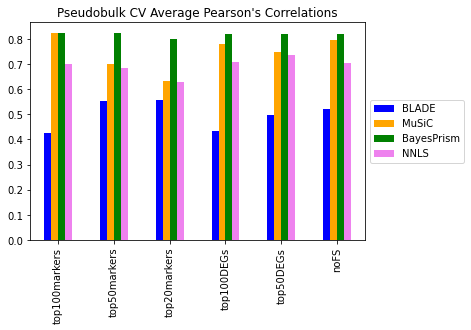

In [38]:
df_evaluation_pseudobulk_corr.plot(kind='bar',title='Pseudobulk CV Average Pearson\'s Correlations',color=['blue','orange','green','violet'])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [20]:
df_evaluation_pseudobulk_rmse

BLADE     MuSiC BayesPrism      NNLS
top100markers  0.106781  0.041135    0.04191  0.059448
top50markers   0.108051  0.057675   0.043905  0.062642
top20markers    0.09736  0.065935   0.049202   0.06894
top100DEGs     0.109078  0.052705   0.040618  0.068473
top50DEGs      0.103315  0.051262    0.04102  0.055544
noFS           0.101872  0.058163   0.039047  0.073244

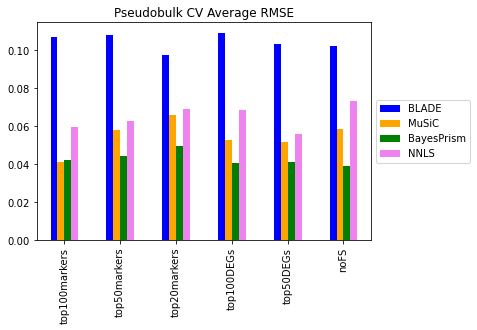

In [40]:
df_evaluation_pseudobulk_rmse.plot(kind='bar',title='Pseudobulk CV Average RMSE',color=['blue','orange','green','violet'])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [158]:
# testing
get_corr_rmse_avgprop(real_res,BayesPrism_top100m_mean)

(0.9723813533814448, 0.028574224970453543)

In [21]:
def plot_scatter_percelltype_merged(dict_res_pseudobulk,list_FSsetup,real_res,list_methods,log=True):
    marker = ['o','v','^','*','h','D']
    for index in range(len(list_FSsetup)):
        methods_res_list = []
        for method in list_method:
            df_res = pd.concat(dict_res_pseudobulk[method][list_FSsetup[index]].values())
            methods_res_list.append(df_res)
            
        fig,axs = plt.subplots(2,5,figsize=(30,10))
        fig.suptitle(list_FSsetup[index],y=0.94,size=14)
        order_method = 0
        for method_res in methods_res_list:
            list_ax = []
            for i in real_res.columns:
                x = []
                y = []
                for j in real_res.index:
                    if j in method_res.index:
                        x.append(real_res.loc[j,i])
                        y.append(method_res.loc[j,i])
                list_ax.append([x,y,i])
            pic = 0
            for ax in axs.flat:
                if True:
                    x = np.where(list_ax[pic][0] != 0, np.log(list_ax[pic][0]), 0)
                    y = np.where(list_ax[pic][1] != 0, np.log(list_ax[pic][1]), 0)
                    lims = [ 
                    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
                    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
                ]
    #                 print(x,y)
                else:
                    x = list_ax[pic][0]
                    y = list_ax[pic][1]
                    lims = [0,1]
                ax.scatter(x,y,label = list_methods[order_method],s=40,alpha=0.7,marker=marker[index])
                ax.set_xlabel('Real proportion')
                ax.set_ylabel('Estimate')
                ax.legend()
                ax.set_title(list_ax[pic][2])
                # now plot both limits against each other
                ax.plot(lims, lims, 'k-', alpha=0.7)
        #             ax.set_aspect('equal')
                pic += 1
            order_method += 1

/tmp/ipykernel_9873/1036987127.py:25: RuntimeWarning: divide by zero encountered in log
  x = np.where(list_ax[pic][0] != 0, np.log(list_ax[pic][0]), 0)
/tmp/ipykernel_9873/1036987127.py:26: RuntimeWarning: divide by zero encountered in log
  y = np.where(list_ax[pic][1] != 0, np.log(list_ax[pic][1]), 0)
/tmp/ipykernel_9873/1036987127.py:25: RuntimeWarning: divide by zero encountered in log
  x = np.where(list_ax[pic][0] != 0, np.log(list_ax[pic][0]), 0)
/tmp/ipykernel_9873/1036987127.py:26: RuntimeWarning: divide by zero encountered in log
  y = np.where(list_ax[pic][1] != 0, np.log(list_ax[pic][1]), 0)
/tmp/ipykernel_9873/1036987127.py:25: RuntimeWarning: divide by zero encountered in log
  x = np.where(list_ax[pic][0] != 0, np.log(list_ax[pic][0]), 0)
/tmp/ipykernel_9873/1036987127.py:26: RuntimeWarning: divide by zero encountered in log
  y = np.where(list_ax[pic][1] != 0, np.log(list_ax[pic][1]), 0)
/tmp/ipykernel_9873/1036987127.py:25: RuntimeWarning: divide by zero encountered i

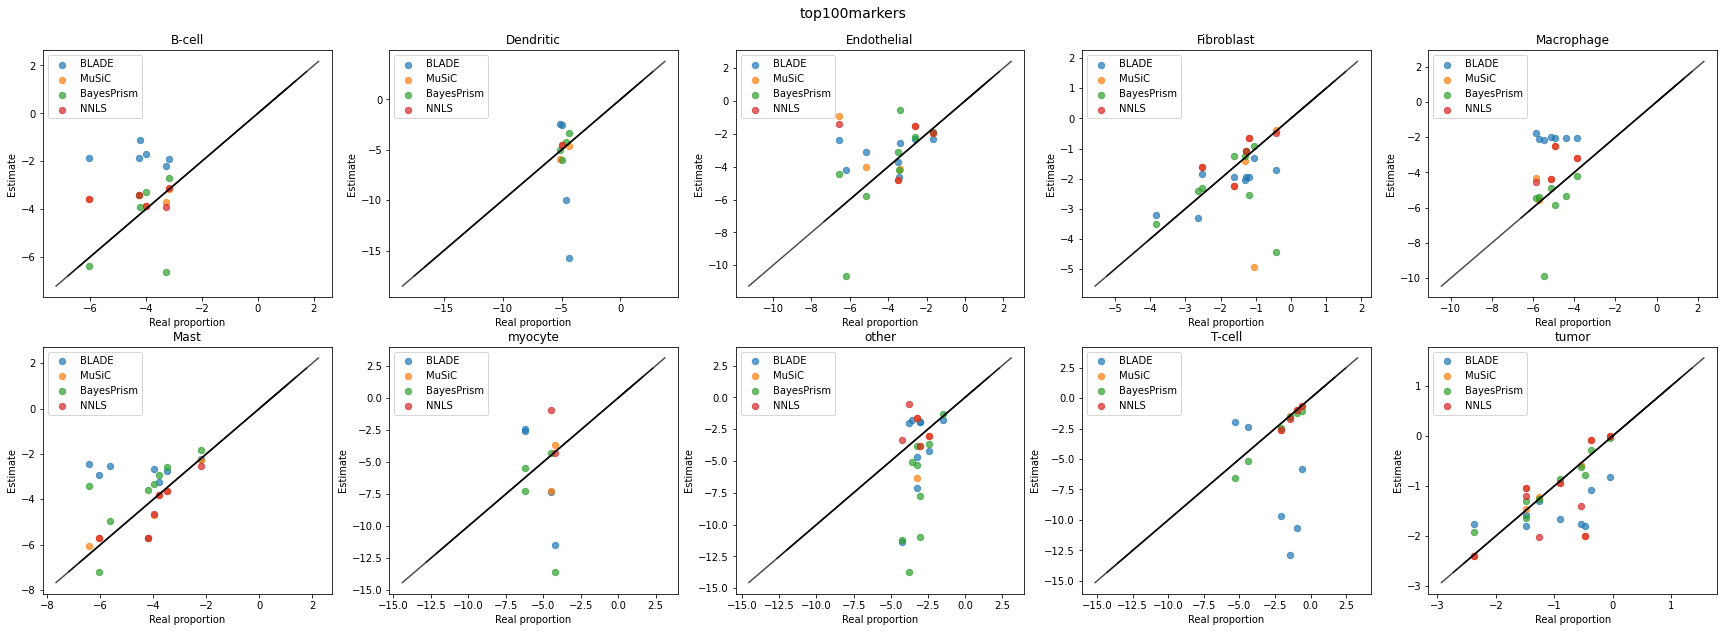

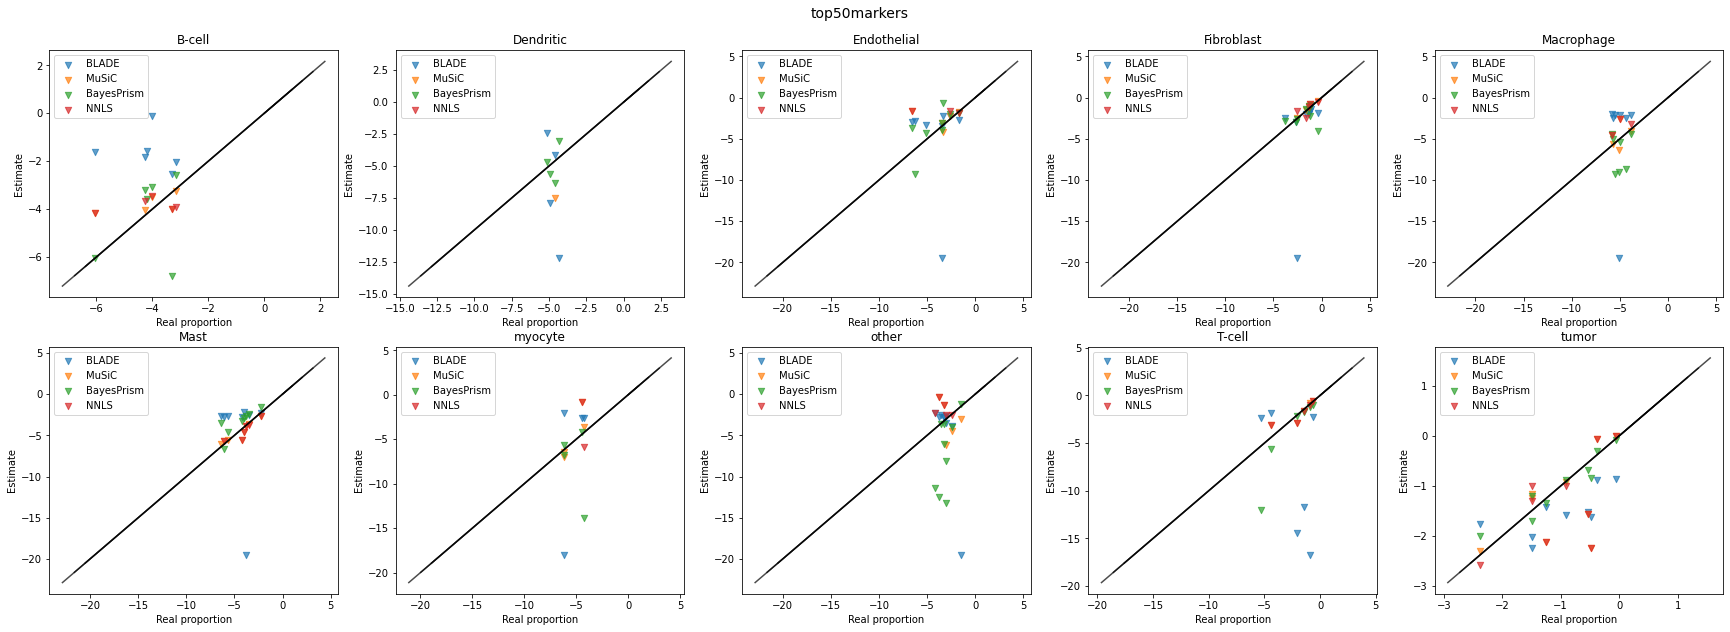

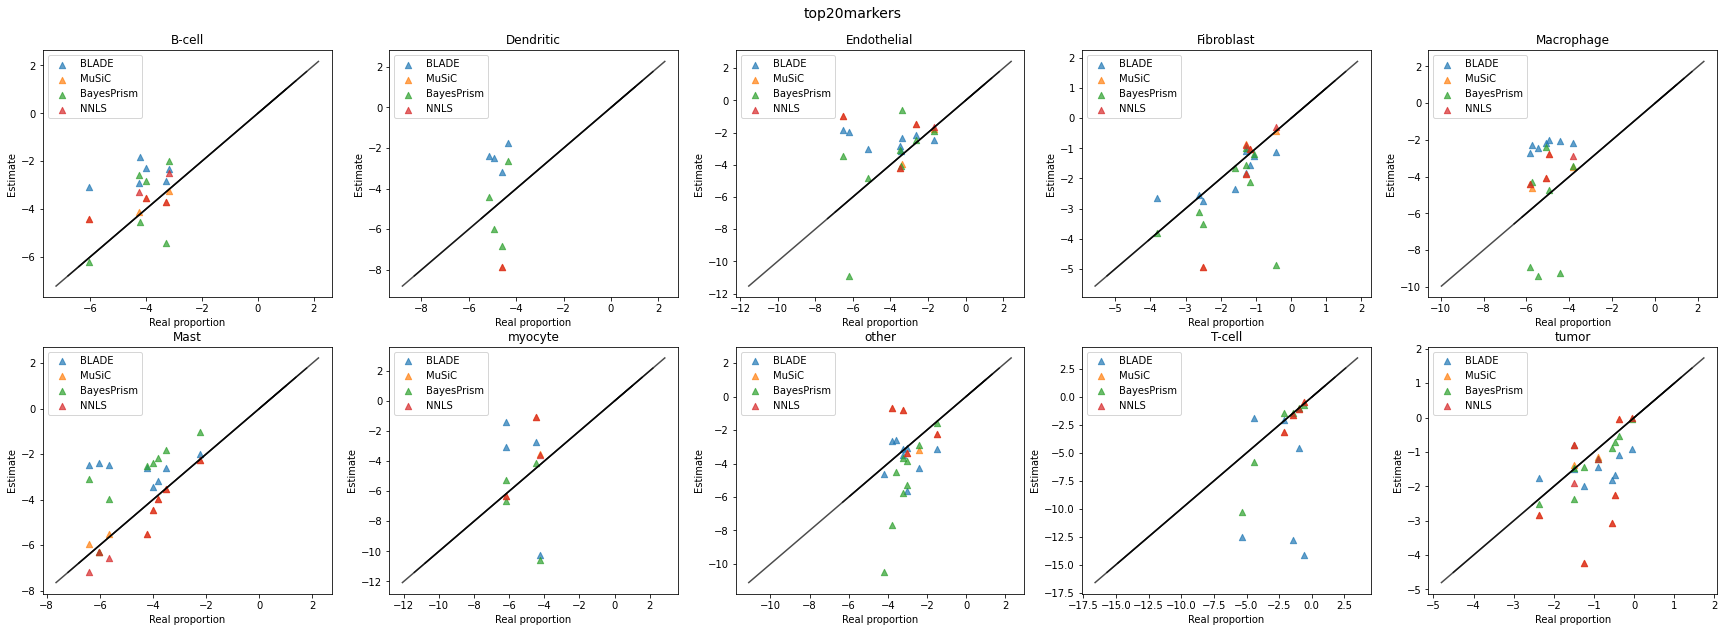

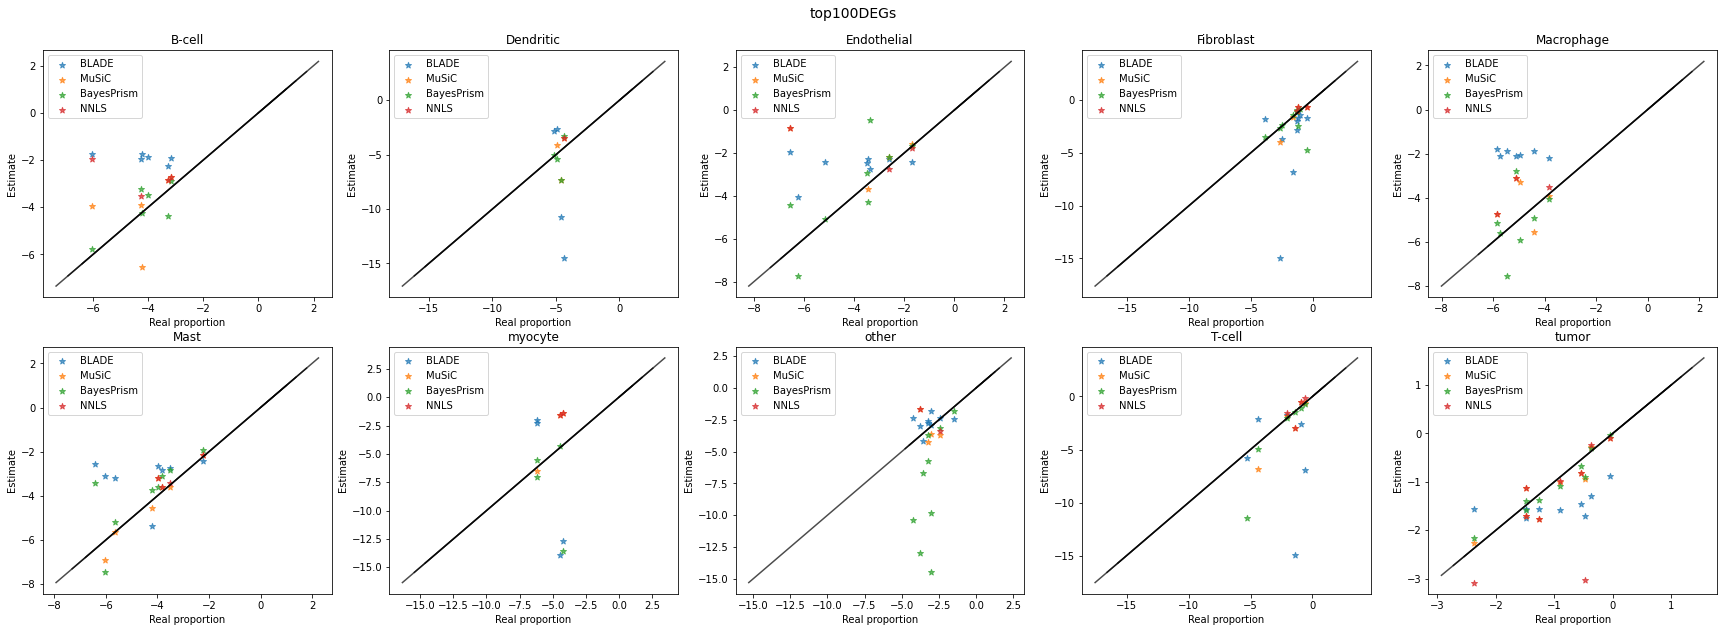

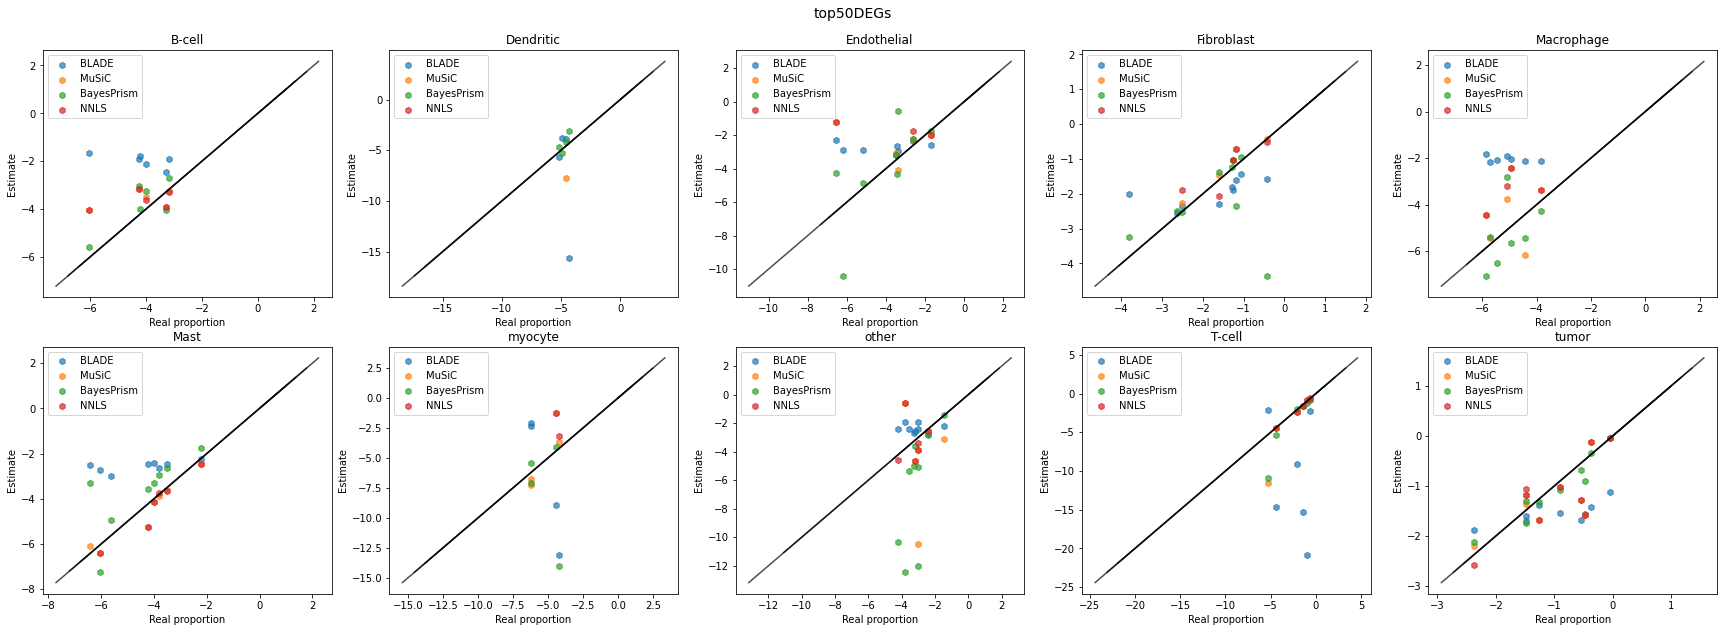

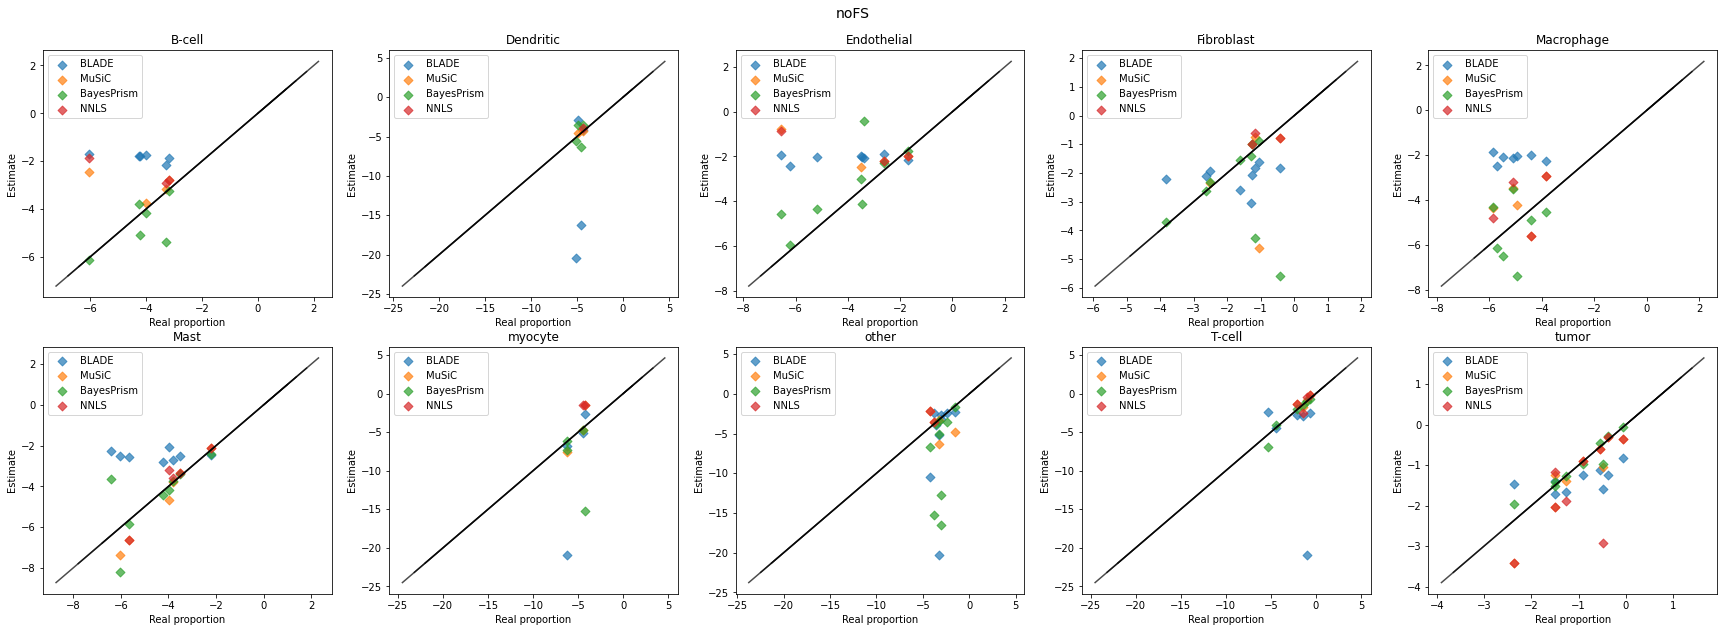

In [42]:
plot_scatter_percelltype_merged(dict_res_pseudobulk,list_FSsetup,real_res,list_method,log=False)

/tmp/ipykernel_28534/3473842876.py:19: RuntimeWarning: divide by zero encountered in log
  x = np.where(list_ax[pic][0] != 0, np.log(list_ax[pic][0]), 0)
/tmp/ipykernel_28534/3473842876.py:20: RuntimeWarning: divide by zero encountered in log
  y = np.where(list_ax[pic][1] != 0, np.log(list_ax[pic][1]), 0)


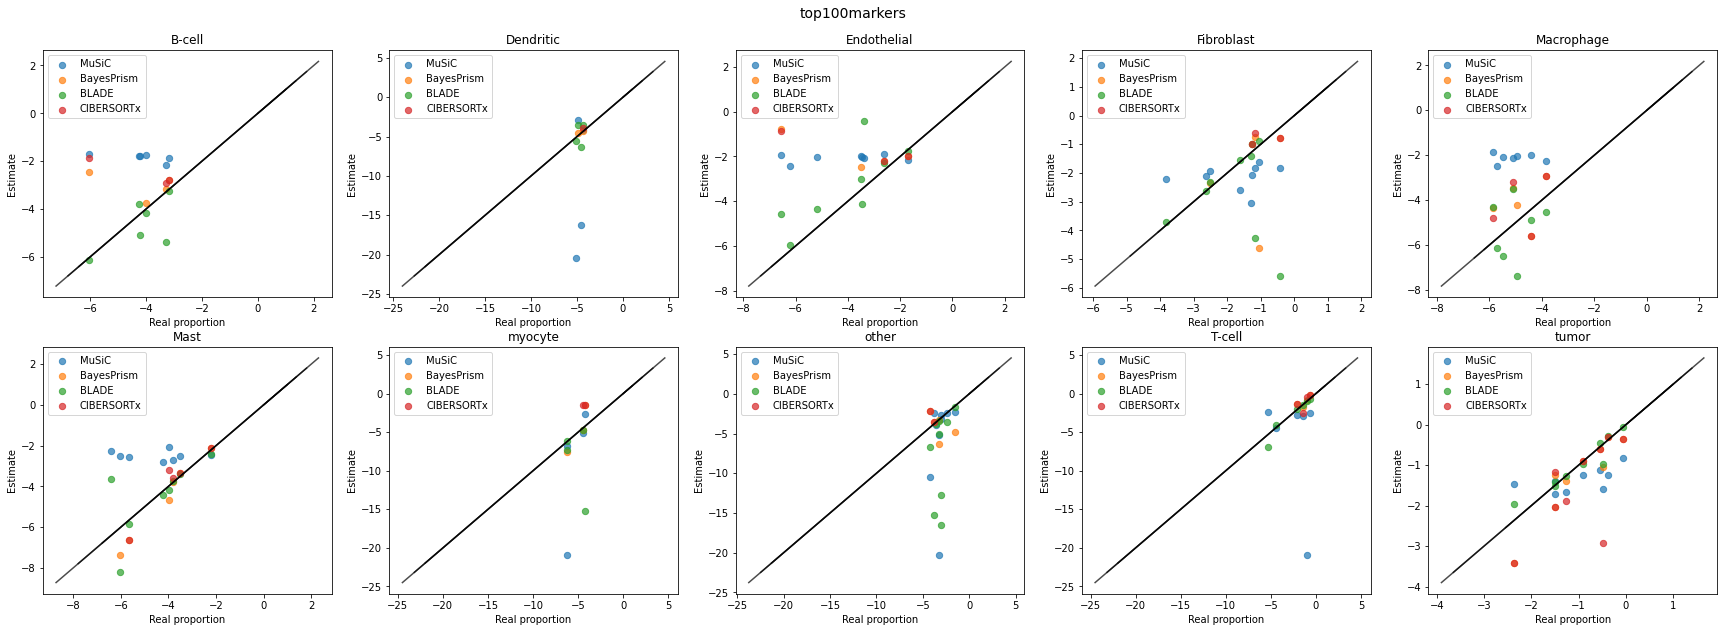

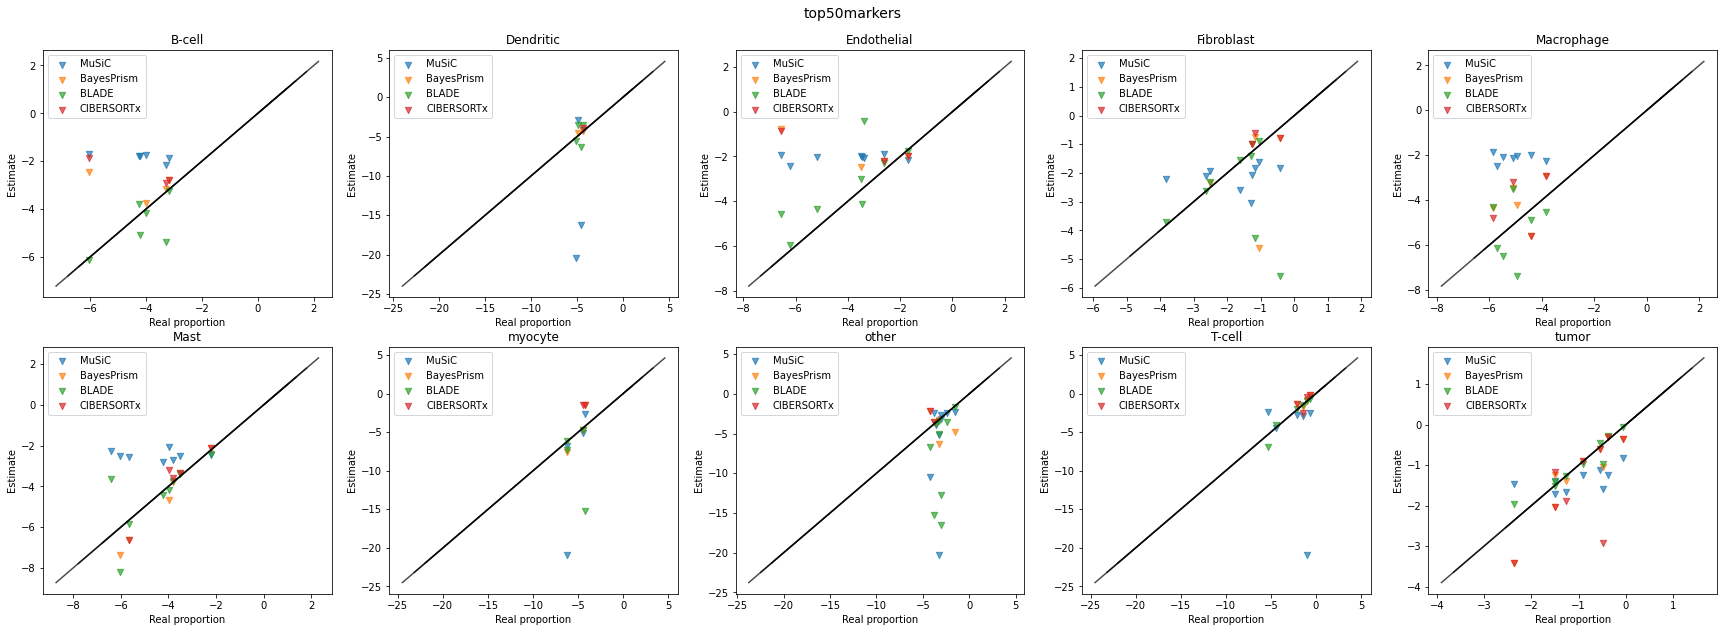

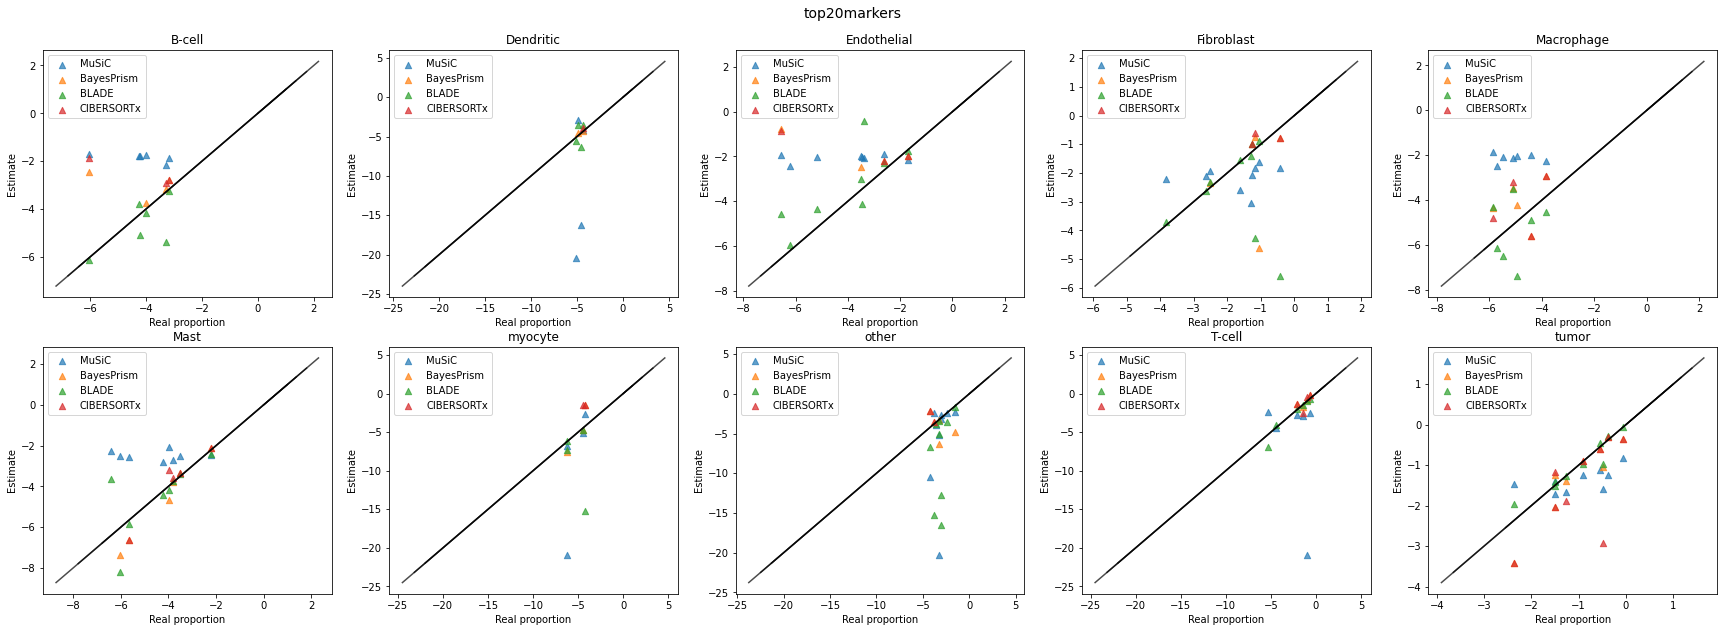

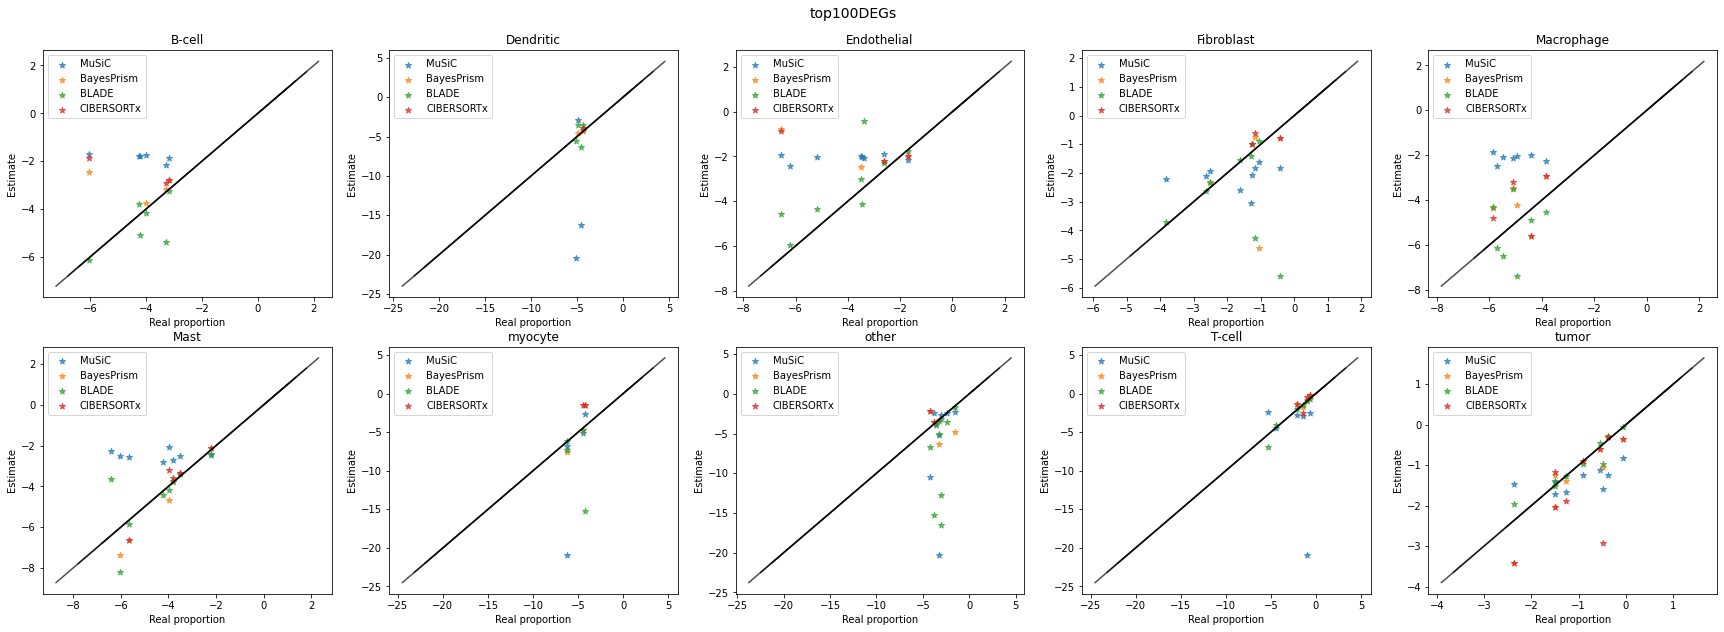

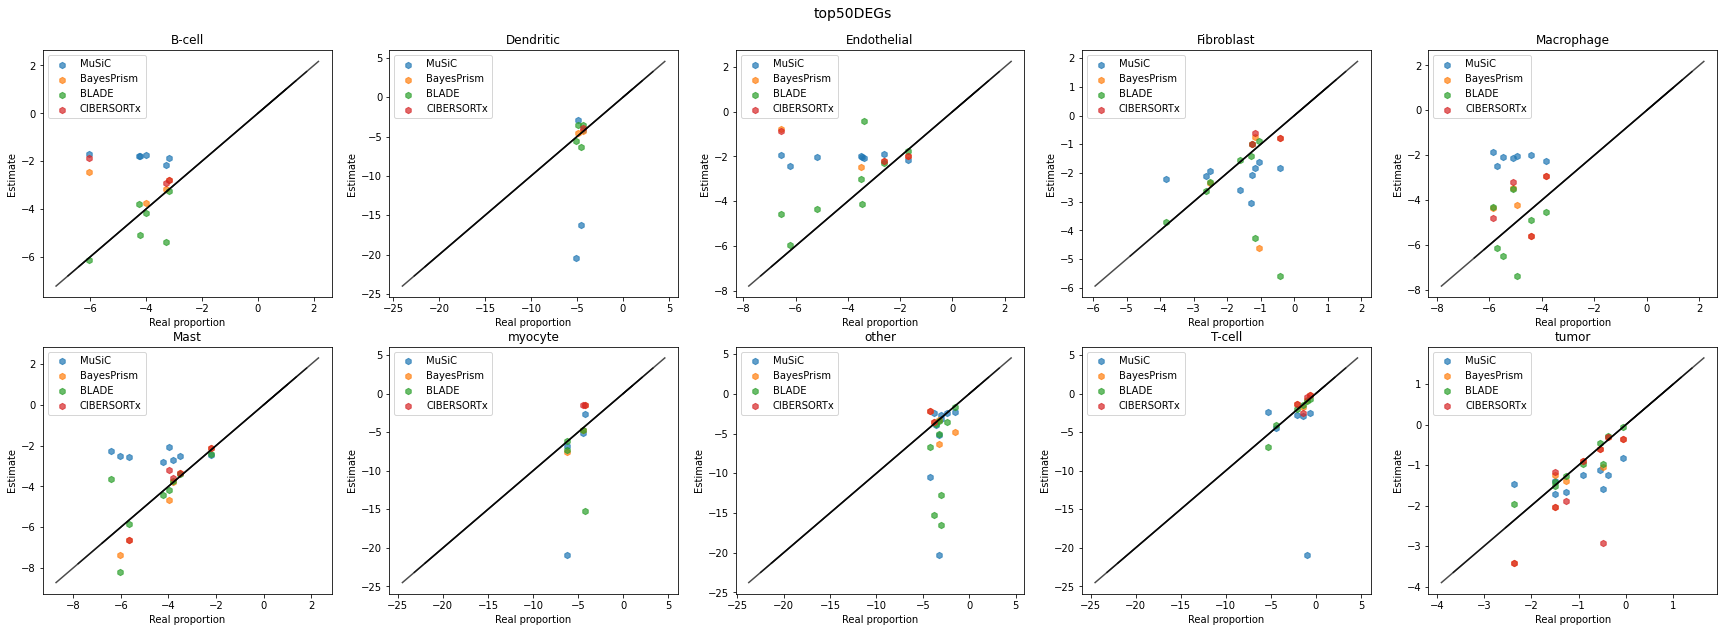

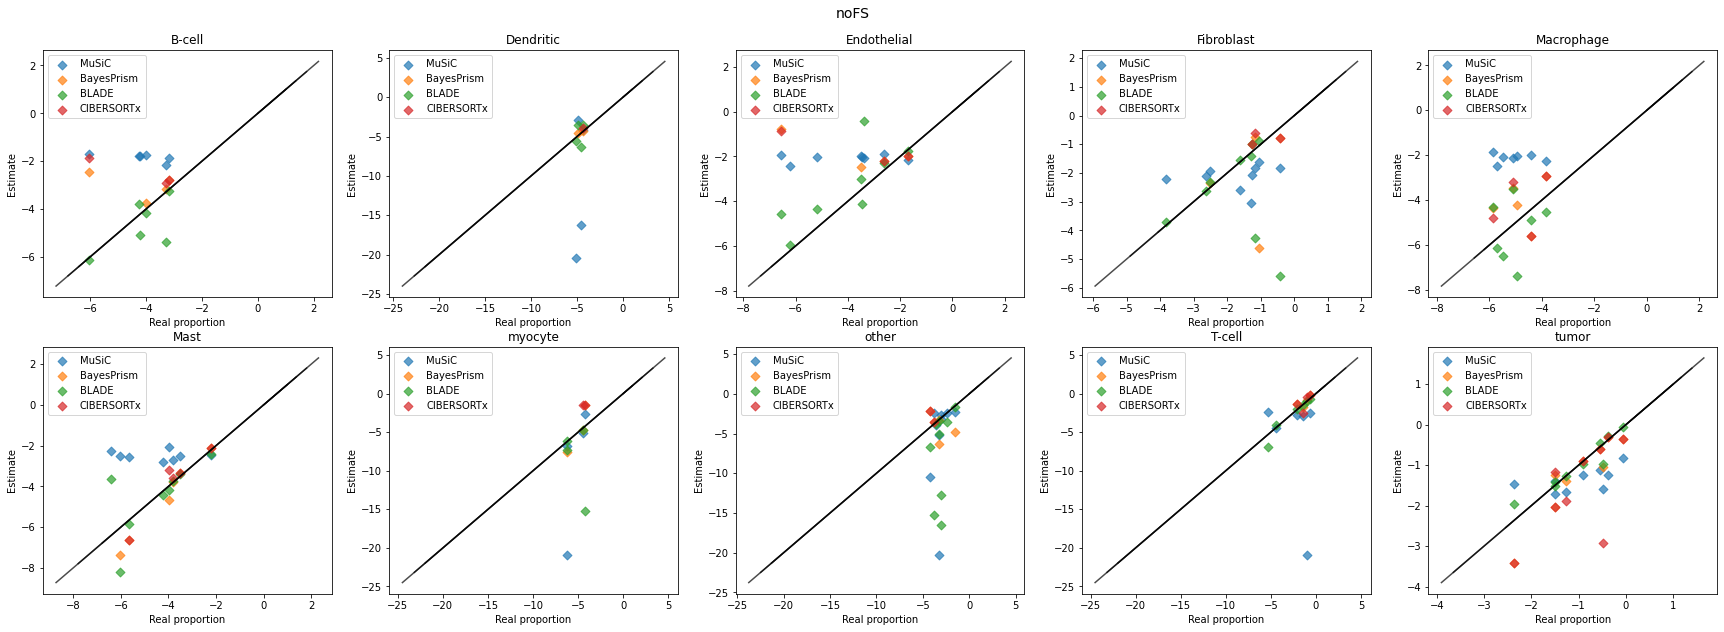

In [238]:
#testing code, ignore
marker = ['o','v','^','*','h','D']
for index in range(len(list_FSsetup)):
    fig,axs = plt.subplots(2,5,figsize=(30,10))
    fig.suptitle(list_FSsetup[index],y=0.94,size=14)
    order_method = 0
    for method_res in methods_res_list:
        list_ax = []
        for i in real_res.columns:
            x = []
            y = []
            for j in real_res.index:
                if j in method_res.index:
                    x.append(real_res.loc[j,i])
                    y.append(method_res.loc[j,i])
            list_ax.append([x,y,i])
        pic = 0
        for ax in axs.flat:
            if True:
                x = np.where(list_ax[pic][0] != 0, np.log(list_ax[pic][0]), 0)
                y = np.where(list_ax[pic][1] != 0, np.log(list_ax[pic][1]), 0)
                lims = [ 
                np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
                np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
            ]
#                 print(x,y)
            else:
                x = list_ax[pic][0]
                y = list_ax[pic][1]
                lims = [0,1]
            ax.scatter(x,y,label = list_methods[order_method],s=40,alpha=0.7,marker=marker[index])
            ax.set_xlabel('Real proportion')
            ax.set_ylabel('Estimate')
            ax.legend()
            ax.set_title(list_ax[pic][2])
            # now plot both limits against each other
            ax.plot(lims, lims, 'k-', alpha=0.7)
    #             ax.set_aspect('equal')
            pic += 1
        order_method += 1

/tmp/ipykernel_28373/3016401405.py:18: RuntimeWarning: divide by zero encountered in log
  x = np.log(list_ax[pic][0])
/tmp/ipykernel_28373/3016401405.py:19: RuntimeWarning: divide by zero encountered in log
  y = np.log(list_ax[pic][1])


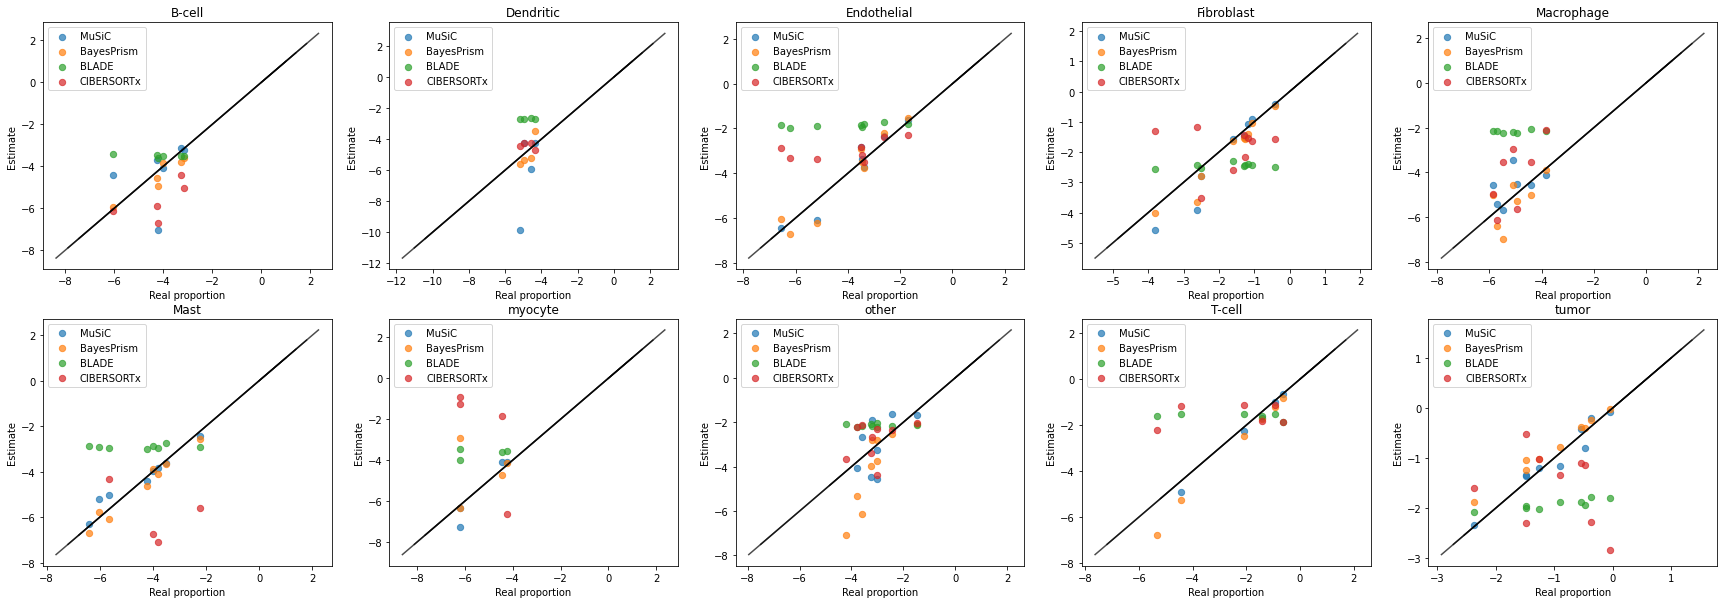

In [26]:
plot_scatter_percelltype_merged([MuSiC_top50m_mean,BayesPrism_top50m_mean,BLADE_top50m_mean,CIBERSORTx_top50m_mean],real_res)

/tmp/ipykernel_28373/3016401405.py:18: RuntimeWarning: divide by zero encountered in log
  x = np.log(list_ax[pic][0])
/tmp/ipykernel_28373/3016401405.py:19: RuntimeWarning: divide by zero encountered in log
  y = np.log(list_ax[pic][1])


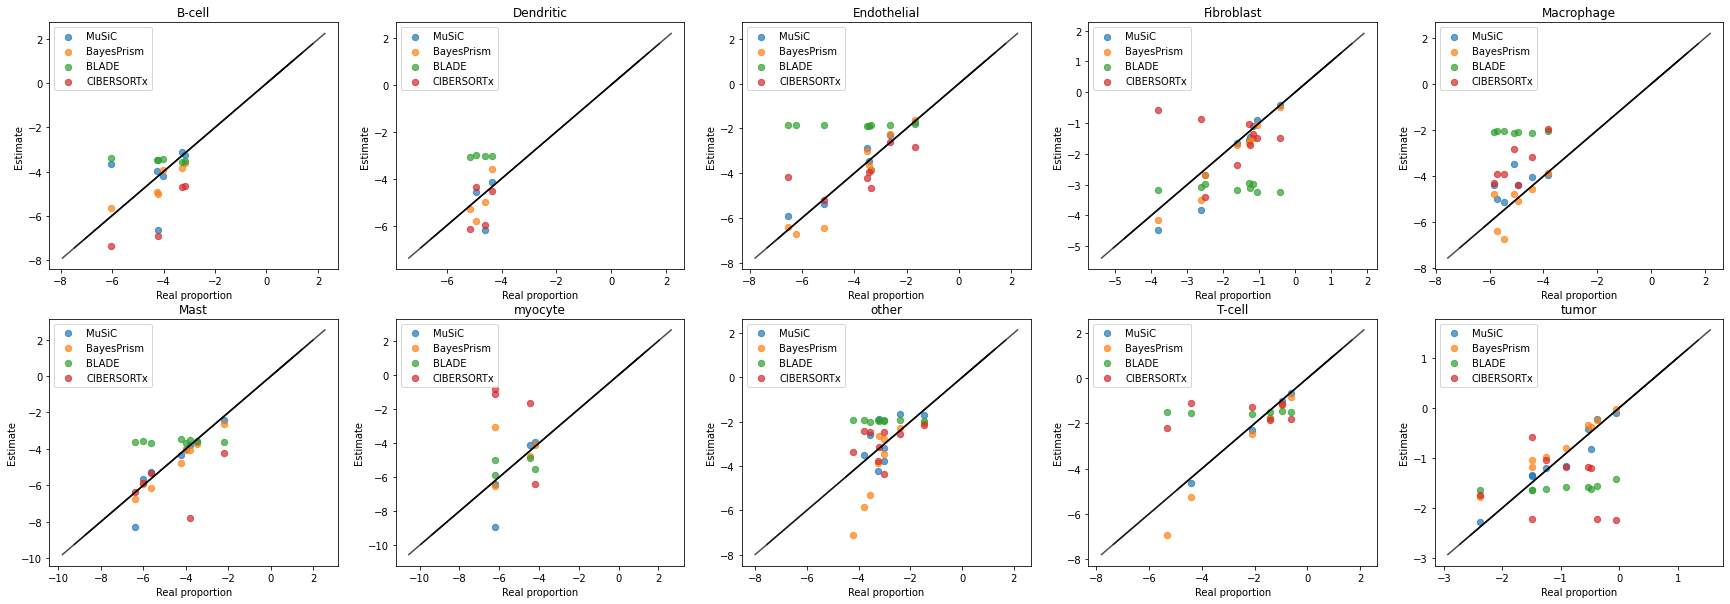

In [27]:
plot_scatter_percelltype_merged([MuSiC_top100m_mean,BayesPrism_top100m_mean,BLADE_top100m_mean,CIBERSORTx_top100m_mean],real_res)

/tmp/ipykernel_28373/3016401405.py:18: RuntimeWarning: divide by zero encountered in log
  x = np.log(list_ax[pic][0])
/tmp/ipykernel_28373/3016401405.py:19: RuntimeWarning: divide by zero encountered in log
  y = np.log(list_ax[pic][1])


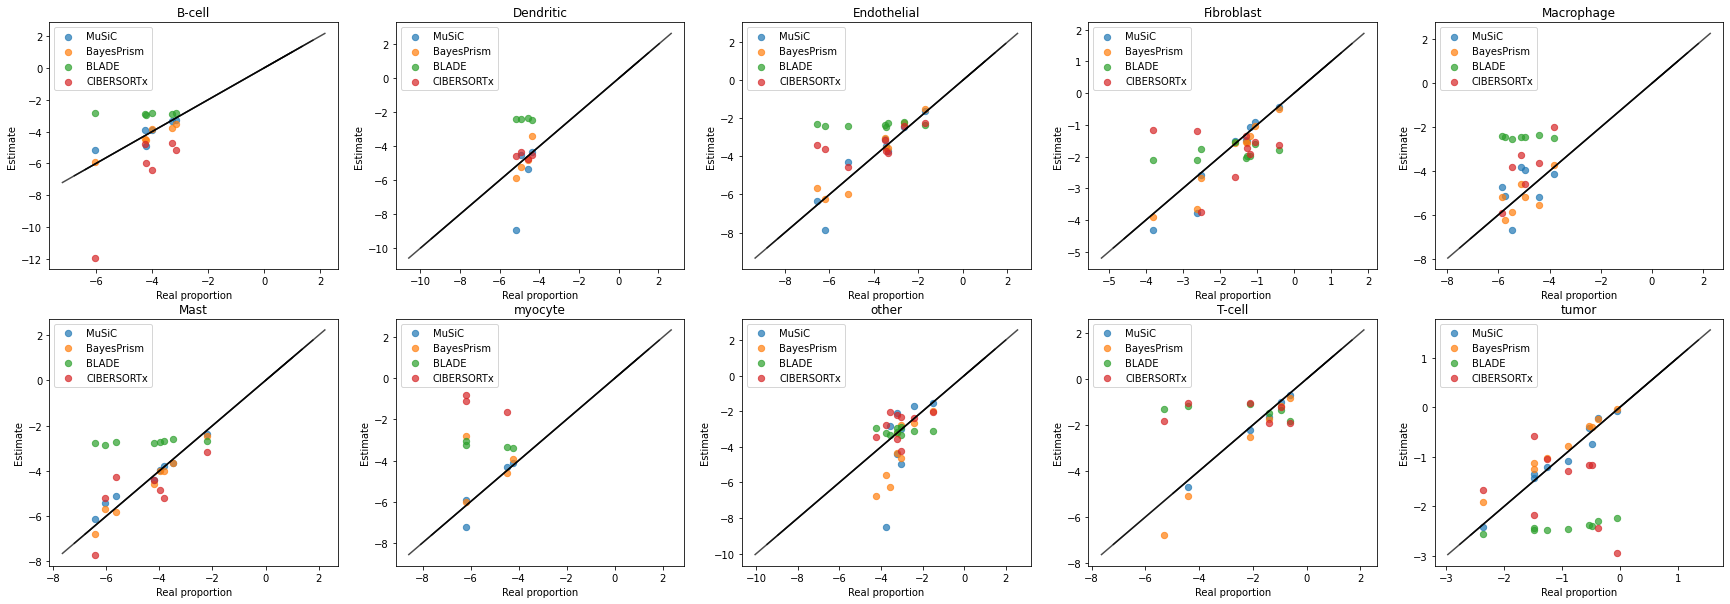

In [28]:
plot_scatter_percelltype_merged([MuSiC_top20m_mean,BayesPrism_top20m_mean,BLADE_top20m_mean,CIBERSORTx_top20m_mean],real_res)

/tmp/ipykernel_28373/3016401405.py:18: RuntimeWarning: divide by zero encountered in log
  x = np.log(list_ax[pic][0])
/tmp/ipykernel_28373/3016401405.py:19: RuntimeWarning: divide by zero encountered in log
  y = np.log(list_ax[pic][1])


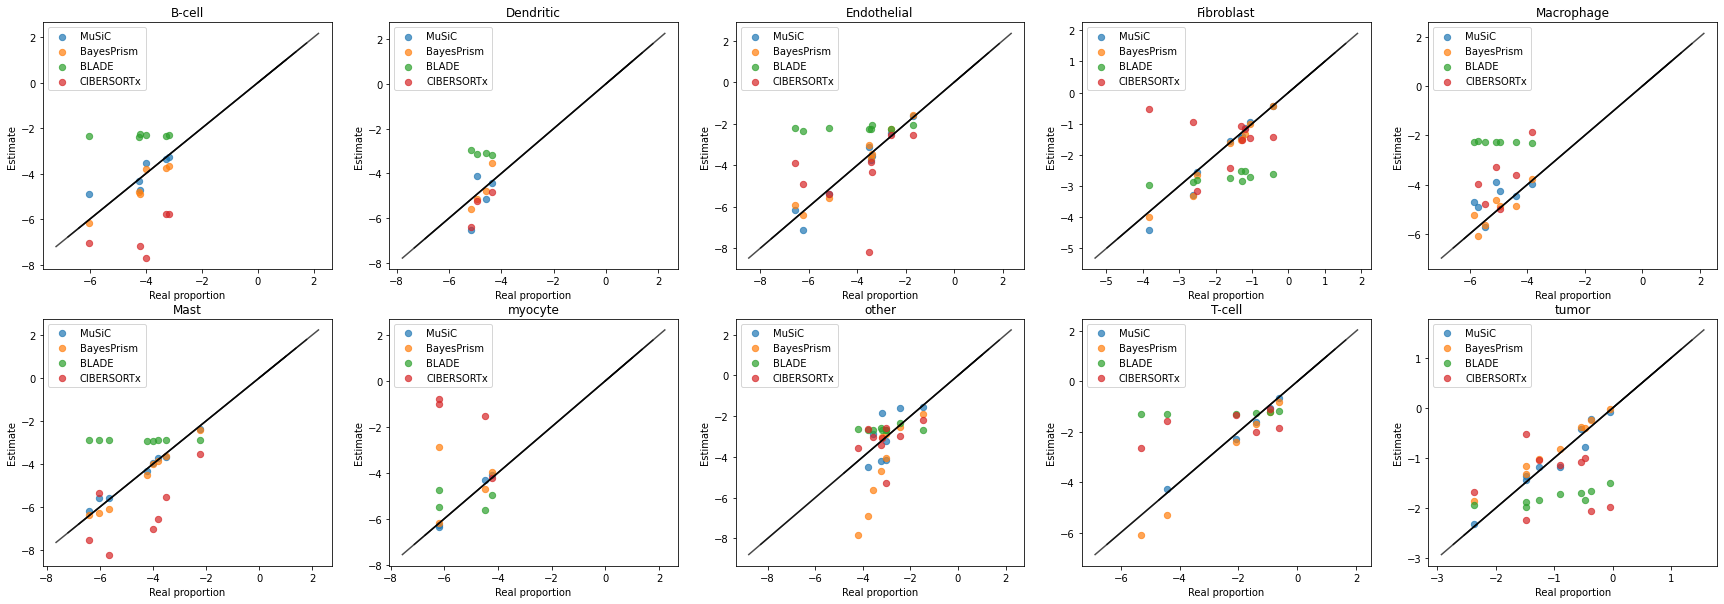

In [29]:
plot_scatter_percelltype_merged([MuSiC_top100D_mean,BayesPrism_top100D_mean,BLADE_top100D_mean,CIBERSORTx_top100D_mean],real_res)

/tmp/ipykernel_28373/3016401405.py:18: RuntimeWarning: divide by zero encountered in log
  x = np.log(list_ax[pic][0])
/tmp/ipykernel_28373/3016401405.py:19: RuntimeWarning: divide by zero encountered in log
  y = np.log(list_ax[pic][1])


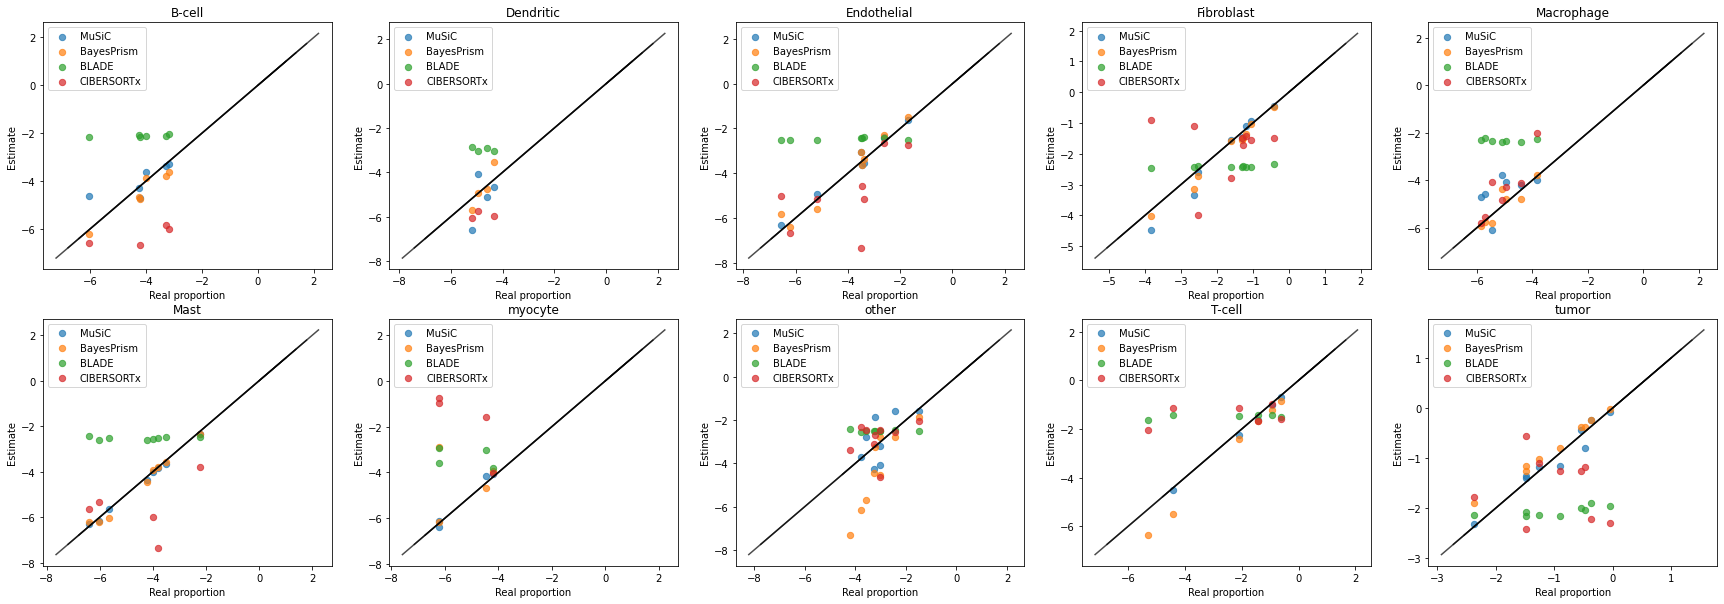

In [30]:
plot_scatter_percelltype_merged([MuSiC_top50D_mean,BayesPrism_top50D_mean,BLADE_top50D_mean,CIBERSORTx_top50D_mean],real_res)

In [43]:
list_res_real

['/home/cke/Real/TCGAResults/BLADE/BLADEreal_Jul29_real_celltypefrac_BLADEout_top100DEGs.csv',
 '/home/cke/Real/TCGAResults/BLADE/fullpipeline_real_Jul28_real_celltypefrac_BLADEout_top50DEGs.csv',
 '/home/cke/Real/TCGAResults/BLADE/BLADEreal_Jul29_real_celltypefrac_BLADEout_top100markers.csv',
 '/home/cke/Real/TCGAResults/BLADE/BLADEreal_Jul29_real_celltypefrac_BLADEout_top20markers.csv',
 '/home/cke/Real/TCGAResults/BLADE/BLADEreal_Jul29_real_celltypefrac_BLADEout_top50markers.csv',
 '/home/cke/Real/TCGAResults/CIBERSORTx/CIBERSORTx_Jul28_real_top100DEGs_celltypefrac.csv',
 '/home/cke/Real/TCGAResults/CIBERSORTx/CIBERSORTx_Jul28_real_top100markers_celltypefrac.csv',
 '/home/cke/Real/TCGAResults/CIBERSORTx/CIBERSORTx_Jul28_real_top50markers_celltypefrac.csv',
 '/home/cke/Real/TCGAResults/CIBERSORTx/CIBERSORTx_Jul28_real_top50DEGs_celltypefrac.csv',
 '/home/cke/Real/TCGAResults/CIBERSORTx/CIBERSORTx_Jul28_real_top20markers_celltypefrac.csv',
 '/home/cke/Real/TCGAResults/BayesPrism/cellt

In [24]:
list_FSsetup_real = ['top100markers',
 'top50markers',
 'top20markers',
 'top100DEGs',
 'top50DEGs','noFS']
list_method_real = ['BLADE','MuSiC','BayesPrism','CIBERSORTx','NNLS']

In [25]:
dict_res_real = {}
for res in list_res_real:
#     print(res)
    for method in list_method_real:
        dict_res_real[method] = {}
            
for res in list_res_real:            
    for method in list_method_real:        
        for FSsetup in list_FSsetup_real:
            if FSsetup in res and method in res:
                print(method, FSsetup)
                print("matched!")
                
                if method != 'CIBERSORTx':
                    df_celltypefrac = pd.read_csv(res,index_col=0,names=colnames,header=0)
                    df_celltypefrac['sample'] = df_celltypefrac.index.tolist()
                    df_celltypefrac['sample'] = df_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
                elif method == 'CIBERSORTx':
                    df_celltypefrac = pd.read_csv(res,index_col=0)
                    df_celltypefrac = df_celltypefrac.drop(['P-value','Correlation','RMSE'],axis=1)
                    df_celltypefrac.columns = ['tumor','Fibroblast', 'Dendritic','other', 'T-cell', 'Mast', 'Macrophage', 'myocyte', 'Endothelial', 'B-cell']
                    df_celltypefrac = df_celltypefrac.loc[:,['B-cell',
                         'Dendritic',
                         'Endothelial',
                         'Fibroblast',
                         'Macrophage',
                         'Mast',
                         'myocyte',
                         'other',
                         'T-cell',
                         'tumor']]
                    df_celltypefrac['sample'] = df_celltypefrac.index.tolist()
                    df_celltypefrac['sample'] = df_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
                dict_res_real[method][FSsetup] = df_celltypefrac

BLADE top100DEGs
matched!
BLADE top50DEGs
matched!
BLADE top100markers
matched!
BLADE top20markers
matched!
BLADE top50markers
matched!
CIBERSORTx top100DEGs
matched!
CIBERSORTx top100markers
matched!
CIBERSORTx top50markers
matched!
CIBERSORTx top50DEGs
matched!
CIBERSORTx top20markers
matched!
BayesPrism top20markers
matched!
BayesPrism top100DEGs
matched!
BayesPrism top50markers
matched!
BayesPrism top50DEGs
matched!
BayesPrism top100markers
matched!
MuSiC top20markers
matched!
MuSiC top20markers
matched!
NNLS top20markers
matched!
MuSiC top100markers
matched!
NNLS top100markers
matched!
MuSiC top50markers
matched!
MuSiC top50markers
matched!
NNLS top50markers
matched!
MuSiC top50DEGs
matched!
MuSiC top100DEGs
matched!
NNLS top100DEGs
matched!
MuSiC top50DEGs
matched!
NNLS top50DEGs
matched!
MuSiC top100markers
matched!
MuSiC top100DEGs
matched!


/tmp/ipykernel_6737/3805349322.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_celltypefrac['sample'] = df_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
/tmp/ipykernel_6737/3805349322.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_celltypefrac['sample'] = df_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
/tmp/ipykernel_6737/3805349322.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_celltypefrac['sample'] = df_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
/

In [26]:
# using cellularity extracted from Kari's plots pdf 
cellularity_Kari = pd.read_csv("/home/cke/KariPDF/cellularity_table.csv",header=None)
cellularity_Kari.columns = ['sample','cellularity']
cellularity_Kari = cellularity_Kari[cellularity_Kari['cellularity']<1.0]
cellularity_Kari

sample  cellularity
0    TCGA-CR-7391-01         0.05
1    TCGA-CN-6995-01         0.34
2    TCGA-CQ-A4C6-01         0.26
3    TCGA-CV-A6K0-01         0.10
4    TCGA-CR-6471-01         0.46
..               ...          ...
519  TCGA-CN-4725-01         0.52
520  TCGA-CV-7440-01         0.40
521  TCGA-CN-4726-01         0.40
522  TCGA-CN-A6V6-01         0.54
523  TCGA-CR-6467-01         0.56

[516 rows x 2 columns]

In [16]:
# using cellularity in table TCGA_ABSOLUTE.txt
# cellularity_Kari = pd.read_csv("/home/cke/Real/TCGA_ABSOLUTE.txt",sep='\t').loc[:,['array','purity']]
# cellularity_Kari.columns = ['sample','cellularity']
# cellularity_Kari = cellularity_Kari[cellularity_Kari['cellularity']<1.0]
# cellularity_Kari

sample  cellularity
0      TCGA-OR-A5J1-01         0.90
1      TCGA-OR-A5J2-01         0.89
2      TCGA-OR-A5J3-01         0.93
3      TCGA-OR-A5J4-01         0.87
4      TCGA-OR-A5J5-01         0.93
...                ...          ...
10780  TCGA-NK-A5D1-01         0.82
10781  TCGA-P6-A5OG-01         0.38
10783  TCGA-RD-A7BW-01         0.18
10784  TCGA-T1-A6J8-01         0.80
10785  TCGA-WB-A820-01         0.72

[10521 rows x 2 columns]

In [27]:
# read in processed raw TCGA counts
df_TCGA_symbol = pd.read_csv("/home/cke/TCGA-HNSC.htseq_counts_exp2_symbol.tsv",sep='\t')
df_TCGA_t = df_TCGA_symbol.T
df_TCGA_t.columns = df_TCGA_t.loc['Gene_symbol',:]
df_TCGA_t.drop('Gene_symbol',axis=0,inplace=True)
df_TCGA_t

Gene_symbol        TSPAN6 TNMD    DPM1   SCYL3 C1orf112     FGR      CFH  \
TCGA-BB-4224-01A   2237.0  2.0  1606.0  1063.0   1208.0   256.0    177.0   
TCGA-H7-7774-01A   2740.0  0.0  1691.0   803.0    317.0   330.0   5472.0   
TCGA-CV-6943-01A   2686.0  0.0  1649.0   917.0    402.0  1535.0  15358.0   
TCGA-CN-5374-01A   2086.0  1.0  2333.0  1288.0   1105.0   639.0   5565.0   
TCGA-CQ-6227-01A  10167.0  9.0  3021.0   537.0    459.0   362.0   6963.0   
...                   ...  ...     ...     ...      ...     ...      ...   
TCGA-CV-7235-01A    492.0  0.0   976.0   376.0    363.0   488.0   5178.0   
TCGA-CX-7086-01A   2741.0  0.0  1952.0  1003.0   1103.0   214.0   1809.0   
TCGA-CV-6935-11A   8492.0  3.0  1578.0   818.0    281.0   419.0   7368.0   
TCGA-P3-A6SW-01A    770.0  1.0  1569.0   620.0    591.0   462.0   2082.0   
TCGA-HD-A6HZ-01A    923.0  0.0  1183.0   607.0    344.0   925.0   2482.0   

Gene_symbol        FUCA2     GCLC    NFYA  ... LINC00550 LINC01394 LINC00602  \
TCGA-BB-4224-01A  2371.0   2741.0  2515.0  ...       6.0       7.0       0.0   
TCGA-H7-7774-01A  2316.0   8370.0   816.0  ...       0.0       1.0       0.0   
TCGA-CV-6943-01A  3490.0   4671.0  2080.0  ...       0.0       4.0       0.0   
TCGA-CN-5374-01A  2065.0   2902.0  1777.0  ...       0.0       0.0       1.0   
TCGA-CQ-6227-01A  4883.0   3140.0  2448.0  ...       1.0       3.0       0.0   
...                  ...      ...     ...  ...       ...       ...       ...   
TCGA-CV-7235-01A  2138.0  20007.0  4131.0  ...       0.0       2.0       2.0   
TCGA-CX-7086-01A  2639.0  13623.0  2530.0  ...       2.0       2.0       0.0   
TCGA-CV-6935-11A  1355.0   2276.0  1583.0  ...       0.0       1.0       0.0   
TCGA-P3-A6SW-01A  1603.0  31675.0  1473.0  ...       0.0       0.0       2.0   
TCGA-HD-A6HZ-01A  1769.0   3949.0   899.0  ...       0.0       1.0       0.0   

Gene_symbol      MIR1291 LINC00891 PAUPAR GIMAP1-GIMAP5 LINC02246 HERC2P7  \
TCGA-BB-4224-01A     2.0       0.0    6.0           0.0      16.0     0.0   
TCGA-H7-7774-01A     0.0       2.0    0.0           0.0       6.0     0.0   
TCGA-CV-6943-01A     2.0       4.0    1.0           0.0      38.0     0.0   
TCGA-CN-5374-01A     0.0       3.0    0.0           0.0       4.0     0.0   
TCGA-CQ-6227-01A     0.0       2.0    0.0           0.0      15.0     0.0   
...                  ...       ...    ...           ...       ...     ...   
TCGA-CV-7235-01A     1.0       0.0    0.0           0.0       8.0     0.0   
TCGA-CX-7086-01A     1.0       0.0    1.0           0.0      11.0     0.0   
TCGA-CV-6935-11A     1.0       0.0    0.0           0.0      12.0     0.0   
TCGA-P3-A6SW-01A     1.0       1.0    0.0           0.0       0.0     1.0   
TCGA-HD-A6HZ-01A     0.0       1.0    0.0           0.0      11.0     1.0   

Gene_symbol      LINC01144  
TCGA-BB-4224-01A     144.0  
TCGA-H7-7774-01A      23.0  
TCGA-CV-6943-01A      18.0  
TCGA-CN-5374-01A      31.0  
TCGA-CQ-6227-01A      24.0  
...                    ...  
TCGA-CV-7235-01A      60.0  
TCGA-CX-7086-01A      77.0  
TCGA-CV-6935-11A      19.0  
TCGA-P3-A6SW-01A      22.0  
TCGA-HD-A6HZ-01A      40.0  

[546 rows x 38929 columns]

In [28]:
df_TCGA_t['sample'] = df_TCGA_t.index.tolist()
df_TCGA_t['sample'] = df_TCGA_t['sample'].str.replace('.','-').str.rstrip('A')
df_TCGA_t

/tmp/ipykernel_6737/1890542009.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_TCGA_t['sample'] = df_TCGA_t['sample'].str.replace('.','-').str.rstrip('A')


Gene_symbol        TSPAN6 TNMD    DPM1   SCYL3 C1orf112     FGR      CFH  \
TCGA-BB-4224-01A   2237.0  2.0  1606.0  1063.0   1208.0   256.0    177.0   
TCGA-H7-7774-01A   2740.0  0.0  1691.0   803.0    317.0   330.0   5472.0   
TCGA-CV-6943-01A   2686.0  0.0  1649.0   917.0    402.0  1535.0  15358.0   
TCGA-CN-5374-01A   2086.0  1.0  2333.0  1288.0   1105.0   639.0   5565.0   
TCGA-CQ-6227-01A  10167.0  9.0  3021.0   537.0    459.0   362.0   6963.0   
...                   ...  ...     ...     ...      ...     ...      ...   
TCGA-CV-7235-01A    492.0  0.0   976.0   376.0    363.0   488.0   5178.0   
TCGA-CX-7086-01A   2741.0  0.0  1952.0  1003.0   1103.0   214.0   1809.0   
TCGA-CV-6935-11A   8492.0  3.0  1578.0   818.0    281.0   419.0   7368.0   
TCGA-P3-A6SW-01A    770.0  1.0  1569.0   620.0    591.0   462.0   2082.0   
TCGA-HD-A6HZ-01A    923.0  0.0  1183.0   607.0    344.0   925.0   2482.0   

Gene_symbol        FUCA2     GCLC    NFYA  ... LINC01394 LINC00602 MIR1291  \
TCGA-BB-4224-01A  2371.0   2741.0  2515.0  ...       7.0       0.0     2.0   
TCGA-H7-7774-01A  2316.0   8370.0   816.0  ...       1.0       0.0     0.0   
TCGA-CV-6943-01A  3490.0   4671.0  2080.0  ...       4.0       0.0     2.0   
TCGA-CN-5374-01A  2065.0   2902.0  1777.0  ...       0.0       1.0     0.0   
TCGA-CQ-6227-01A  4883.0   3140.0  2448.0  ...       3.0       0.0     0.0   
...                  ...      ...     ...  ...       ...       ...     ...   
TCGA-CV-7235-01A  2138.0  20007.0  4131.0  ...       2.0       2.0     1.0   
TCGA-CX-7086-01A  2639.0  13623.0  2530.0  ...       2.0       0.0     1.0   
TCGA-CV-6935-11A  1355.0   2276.0  1583.0  ...       1.0       0.0     1.0   
TCGA-P3-A6SW-01A  1603.0  31675.0  1473.0  ...       0.0       2.0     1.0   
TCGA-HD-A6HZ-01A  1769.0   3949.0   899.0  ...       1.0       0.0     0.0   

Gene_symbol      LINC00891 PAUPAR GIMAP1-GIMAP5 LINC02246 HERC2P7 LINC01144  \
TCGA-BB-4224-01A       0.0    6.0           0.0      16.0     0.0     144.0   
TCGA-H7-7774-01A       2.0    0.0           0.0       6.0     0.0      23.0   
TCGA-CV-6943-01A       4.0    1.0           0.0      38.0     0.0      18.0   
TCGA-CN-5374-01A       3.0    0.0           0.0       4.0     0.0      31.0   
TCGA-CQ-6227-01A       2.0    0.0           0.0      15.0     0.0      24.0   
...                    ...    ...           ...       ...     ...       ...   
TCGA-CV-7235-01A       0.0    0.0           0.0       8.0     0.0      60.0   
TCGA-CX-7086-01A       0.0    1.0           0.0      11.0     0.0      77.0   
TCGA-CV-6935-11A       0.0    0.0           0.0      12.0     0.0      19.0   
TCGA-P3-A6SW-01A       1.0    0.0           0.0       0.0     1.0      22.0   
TCGA-HD-A6HZ-01A       1.0    0.0           0.0      11.0     1.0      40.0   

Gene_symbol                sample  
TCGA-BB-4224-01A  TCGA-BB-4224-01  
TCGA-H7-7774-01A  TCGA-H7-7774-01  
TCGA-CV-6943-01A  TCGA-CV-6943-01  
TCGA-CN-5374-01A  TCGA-CN-5374-01  
TCGA-CQ-6227-01A  TCGA-CQ-6227-01  
...                           ...  
TCGA-CV-7235-01A  TCGA-CV-7235-01  
TCGA-CX-7086-01A  TCGA-CX-7086-01  
TCGA-CV-6935-11A  TCGA-CV-6935-11  
TCGA-P3-A6SW-01A  TCGA-P3-A6SW-01  
TCGA-HD-A6HZ-01A  TCGA-HD-A6HZ-01  

[546 rows x 38930 columns]

In [29]:
merged_TCGA_cellularity = pd.merge(df_TCGA_t,cellularity_Kari,left_on='sample',right_on='sample',how='inner')
merged_TCGA_cellularity

TSPAN6 TNMD    DPM1   SCYL3 C1orf112     FGR      CFH   FUCA2     GCLC  \
0     2237.0  2.0  1606.0  1063.0   1208.0   256.0    177.0  2371.0   2741.0   
1     2740.0  0.0  1691.0   803.0    317.0   330.0   5472.0  2316.0   8370.0   
2     2686.0  0.0  1649.0   917.0    402.0  1535.0  15358.0  3490.0   4671.0   
3     2086.0  1.0  2333.0  1288.0   1105.0   639.0   5565.0  2065.0   2902.0   
4    10167.0  9.0  3021.0   537.0    459.0   362.0   6963.0  4883.0   3140.0   
..       ...  ...     ...     ...      ...     ...      ...     ...      ...   
479   2218.0  0.0  1574.0   852.0    729.0   550.0   5558.0  2921.0   8749.0   
480    492.0  0.0   976.0   376.0    363.0   488.0   5178.0  2138.0  20007.0   
481   2741.0  0.0  1952.0  1003.0   1103.0   214.0   1809.0  2639.0  13623.0   
482    770.0  1.0  1569.0   620.0    591.0   462.0   2082.0  1603.0  31675.0   
483    923.0  0.0  1183.0   607.0    344.0   925.0   2482.0  1769.0   3949.0   

       NFYA  ... LINC00602 MIR1291 LINC00891 PAUPAR GIMAP1-GIMAP5 LINC02246  \
0    2515.0  ...       0.0     2.0       0.0    6.0           0.0      16.0   
1     816.0  ...       0.0     0.0       2.0    0.0           0.0       6.0   
2    2080.0  ...       0.0     2.0       4.0    1.0           0.0      38.0   
3    1777.0  ...       1.0     0.0       3.0    0.0           0.0       4.0   
4    2448.0  ...       0.0     0.0       2.0    0.0           0.0      15.0   
..      ...  ...       ...     ...       ...    ...           ...       ...   
479  1596.0  ...       0.0     0.0       2.0    0.0           0.0      17.0   
480  4131.0  ...       2.0     1.0       0.0    0.0           0.0       8.0   
481  2530.0  ...       0.0     1.0       0.0    1.0           0.0      11.0   
482  1473.0  ...       2.0     1.0       1.0    0.0           0.0       0.0   
483   899.0  ...       0.0     0.0       1.0    0.0           0.0      11.0   

    HERC2P7 LINC01144           sample cellularity  
0       0.0     144.0  TCGA-BB-4224-01        0.59  
1       0.0      23.0  TCGA-H7-7774-01        0.48  
2       0.0      18.0  TCGA-CV-6943-01        0.19  
3       0.0      31.0  TCGA-CN-5374-01        0.36  
4       0.0      24.0  TCGA-CQ-6227-01        0.26  
..      ...       ...              ...         ...  
479     0.0      54.0  TCGA-CN-6010-01        0.36  
480     0.0      60.0  TCGA-CV-7235-01        0.40  
481     0.0      77.0  TCGA-CX-7086-01        0.61  
482     1.0      22.0  TCGA-P3-A6SW-01        0.28  
483     1.0      40.0  TCGA-HD-A6HZ-01        0.31  

[484 rows x 38931 columns]

In [30]:
def plot_estimates_cellularity(method_celltypefrac,cellularity_Kari):
    celltype_cellularity = pd.merge(method_celltypefrac,cellularity_Kari,on='sample')
    celltype_cellularity.plot('cellularity','tumor',kind='scatter',xlabel='DNA cellularity',ylabel='Estimated tumor percentage')
    pearsoncorr = pearsonr(celltype_cellularity['tumor'],celltype_cellularity['cellularity'])[0]
    rmse = mean_squared_error(celltype_cellularity['cellularity'], celltype_cellularity['tumor'], squared=False)
    r2 = r2_score(celltype_cellularity['cellularity'], celltype_cellularity['tumor'])
    print('Pearson\'s correlation: ',pearsoncorr,'rmse: ',rmse ,"r2 score: ",r2)
    return celltype_cellularity,pearsoncorr,rmse

In [31]:
dict_res_real

{'BLADE': {'top100DEGs':                     B-cell  Dendritic  Endothelial  Fibroblast  Macrophage  \
  TCGA-BB-4224-01A  0.110155   0.082276     0.090580    0.073772    0.092134   
  TCGA-H7-7774-01A  0.109487   0.075637     0.076346    0.075072    0.096393   
  TCGA-CV-6943-01A  0.130840   0.072967     0.068045    0.062099    0.136764   
  TCGA-CN-5374-01A  0.107474   0.078778     0.091111    0.065035    0.115079   
  TCGA-CQ-6227-01A  0.118833   0.070999     0.067763    0.043931    0.099183   
  ...                    ...        ...          ...         ...         ...   
  TCGA-CV-7235-01A  0.117771   0.061181     0.095704    0.051833    0.096123   
  TCGA-CX-7086-01A  0.107289   0.075142     0.087155    0.079373    0.087339   
  TCGA-CV-6935-11A  0.109346   0.078461     0.086953    0.072065    0.089097   
  TCGA-P3-A6SW-01A  0.121893   0.080804     0.072299    0.062636    0.098041   
  TCGA-HD-A6HZ-01A  0.053051   0.084226     0.096566    0.075649    0.105036   
  
              

Pearson's correlation:  0.018115528693327467 rmse:  0.28560440769020534 r2 score:  -1.8216162088611751
Pearson's correlation:  0.018115528693327467 rmse:  0.28560440769020534 r2 score:  -1.8216162088611751
Pearson's correlation:  0.012939009360250737 rmse:  0.24642749011959536 r2 score:  -1.1006148814802028
Pearson's correlation:  0.012939009360250737 rmse:  0.24642749011959536 r2 score:  -1.1006148814802028
Pearson's correlation:  0.0668643766131652 rmse:  0.21957795634896388 r2 score:  -0.6678062914375531
Pearson's correlation:  0.0668643766131652 rmse:  0.21957795634896388 r2 score:  -0.6678062914375531
Pearson's correlation:  -0.044140870905106704 rmse:  0.2029765073992219 r2 score:  -0.42514705959449217
Pearson's correlation:  -0.044140870905106704 rmse:  0.2029765073992219 r2 score:  -0.42514705959449217
Pearson's correlation:  -0.11141784169590316 rmse:  0.2265422986275734 r2 score:  -0.7752794912783179
Pearson's correlation:  -0.11141784169590316 rmse:  0.2265422986275734 r2 sc

/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Pearson's correlation:  0.272125101561991 rmse:  0.42440957842695765 r2 score:  -5.230723572179645
Pearson's correlation:  0.272125101561991 rmse:  0.42440957842695765 r2 score:  -5.230723572179645
Pearson's correlation:  0.3362585928131938 rmse:  0.3481630488111595 r2 score:  -3.1930832388240473
Pearson's correlation:  0.3362585928131938 rmse:  0.3481630488111595 r2 score:  -3.1930832388240473
Pearson's correlation:  0.33959275587327836 rmse:  0.35874009876813073 r2 score:  -3.4517213984789006
Pearson's correlation:  0.33959275587327836 rmse:  0.35874009876813073 r2 score:  -3.4517213984789006
Pearson's correlation:  -0.1628339094725728 rmse:  0.4144578719300101 r2 score:  -4.941948944458334
Pearson's correlation:  -0.1628339094725728 rmse:  0.4144578719300101 r2 score:  -4.941948944458334
Pearson's correlation:  -0.1270499002162896 rmse:  0.42721897404991344 r2 score:  -5.313485623298276
Pearson's correlation:  -0.1270499002162896 rmse:  0.42721897404991344 r2 score:  -5.313485623298

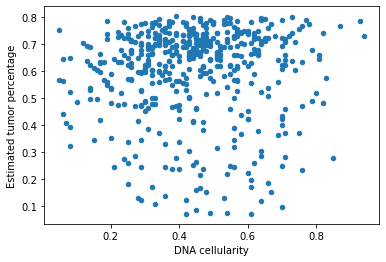

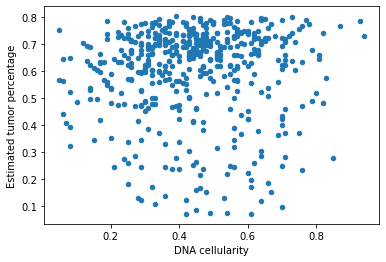

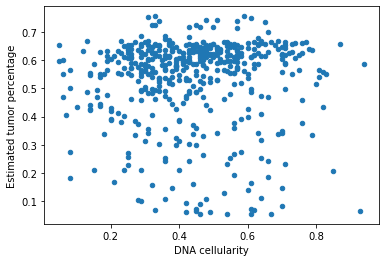

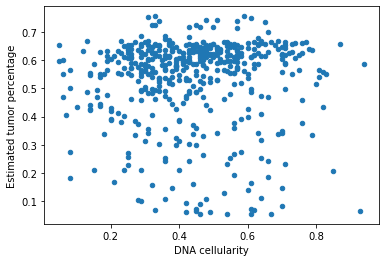

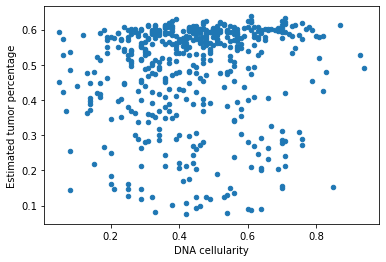

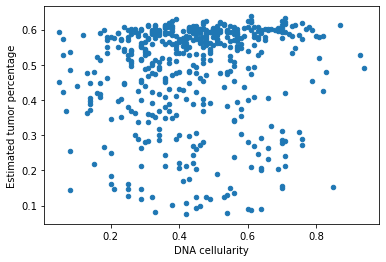

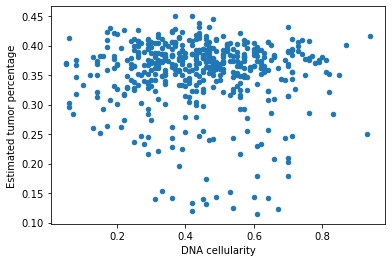

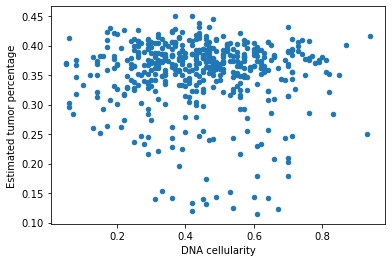

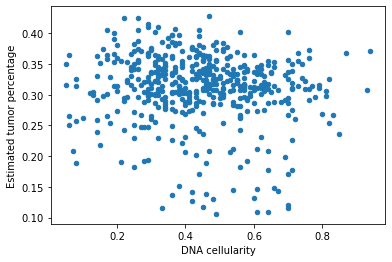

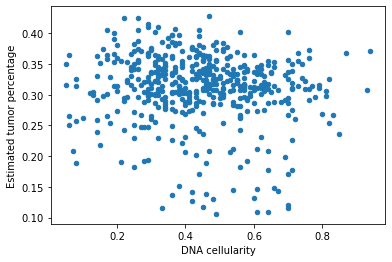

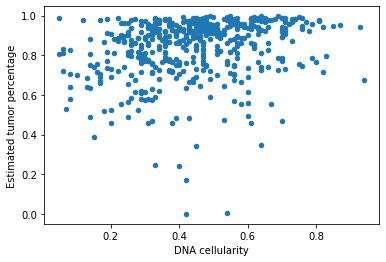

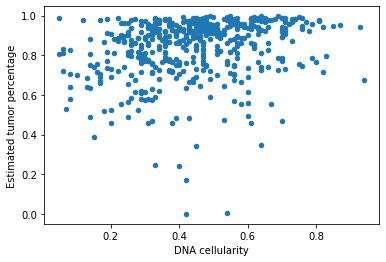

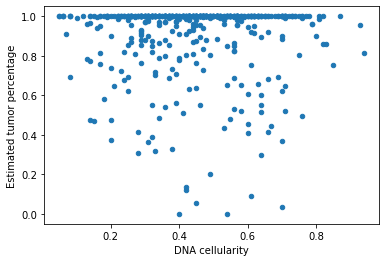

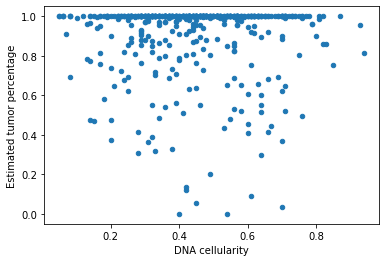

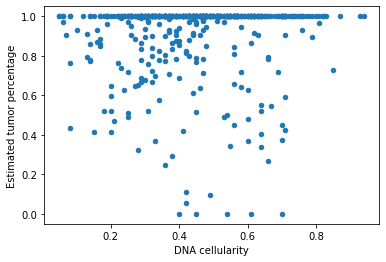

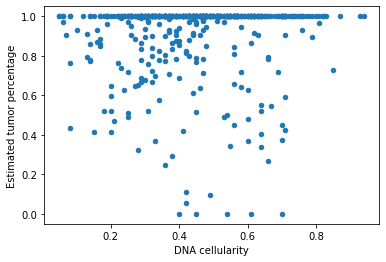

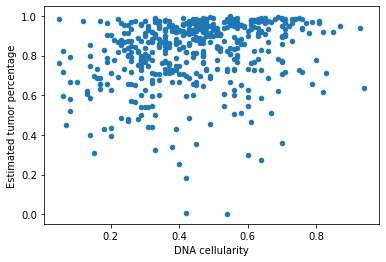

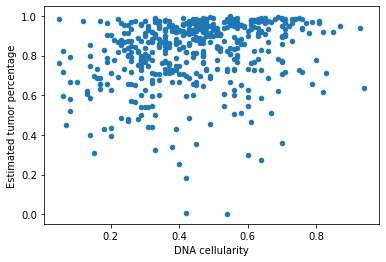

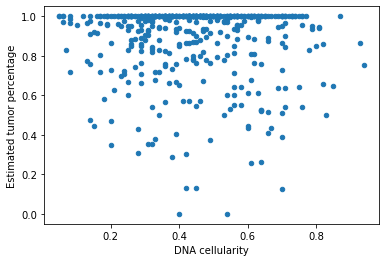

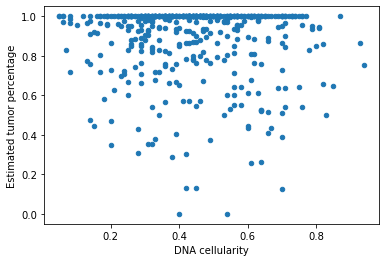

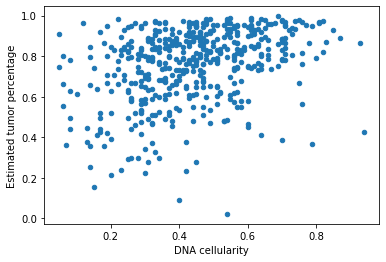

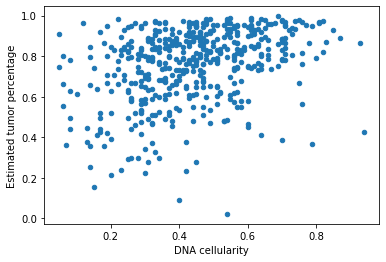

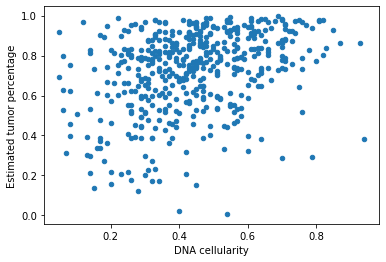

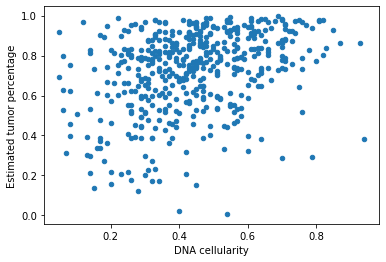

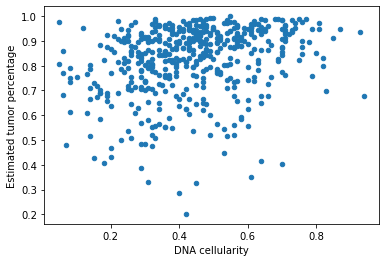

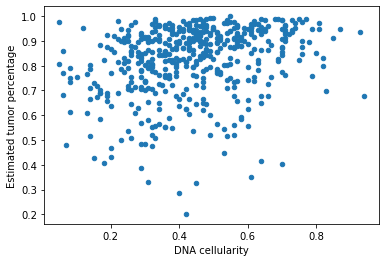

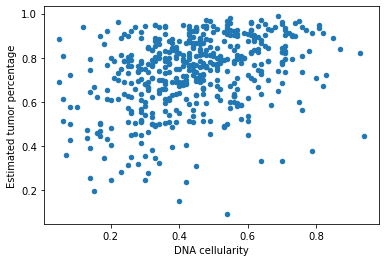

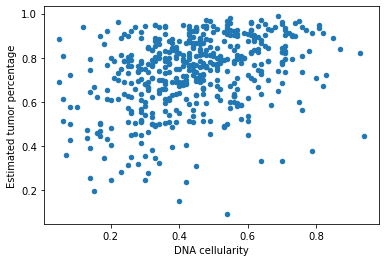

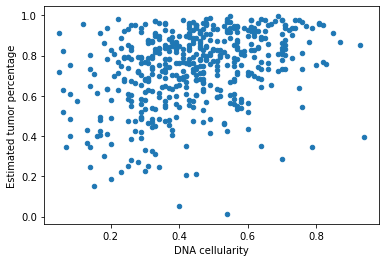

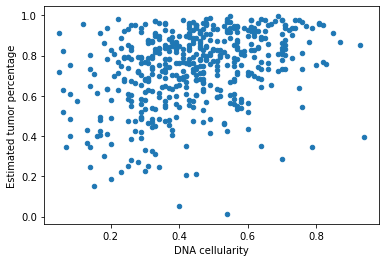

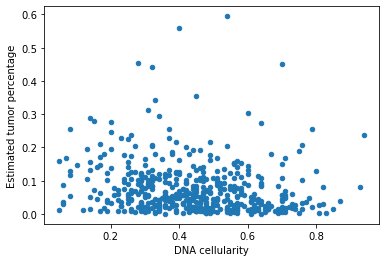

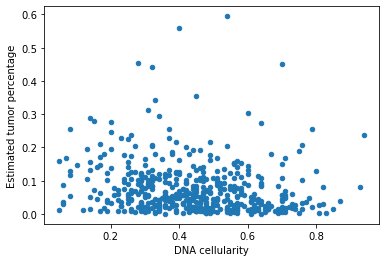

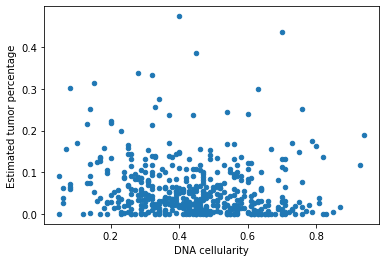

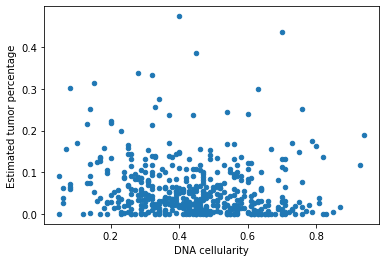

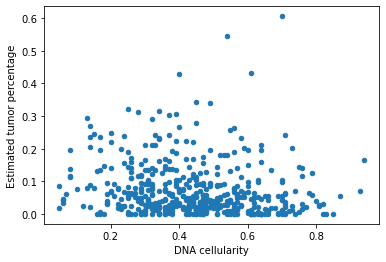

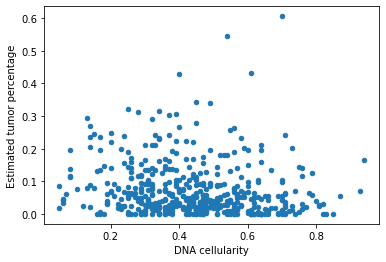

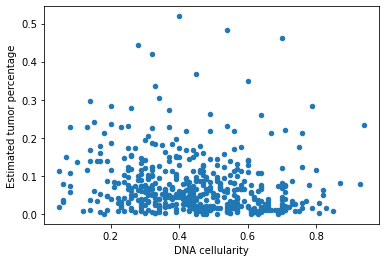

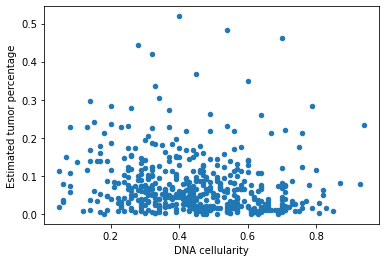

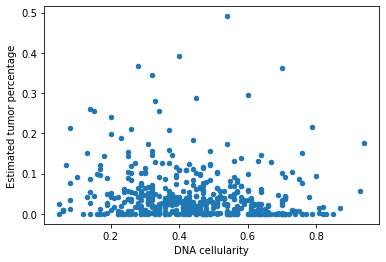

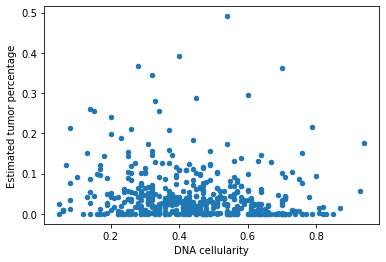

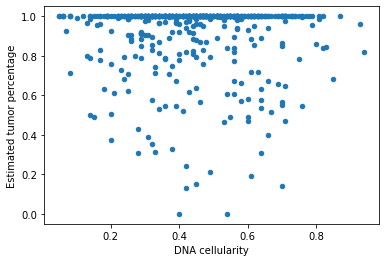

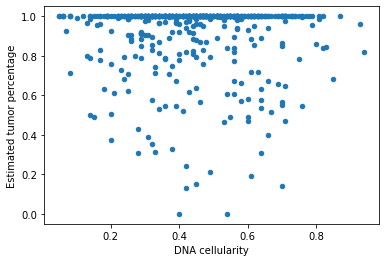

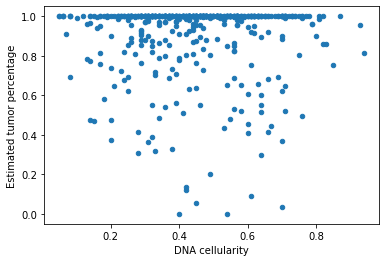

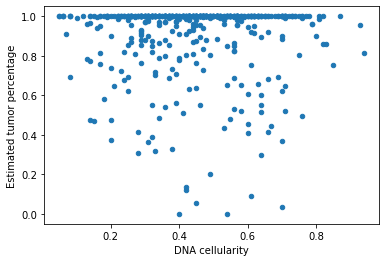

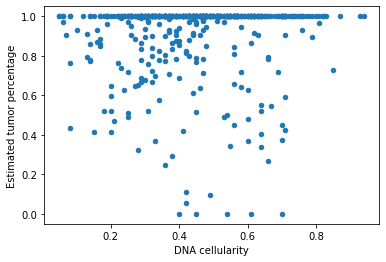

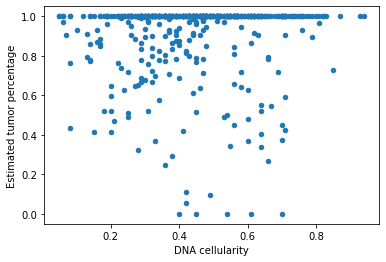

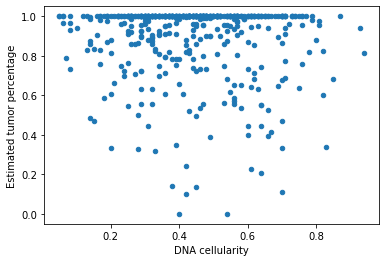

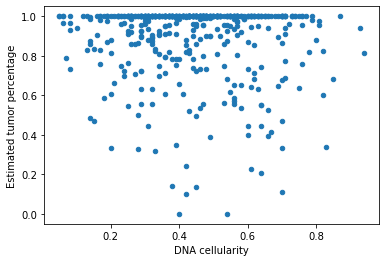

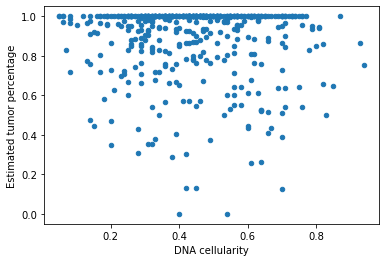

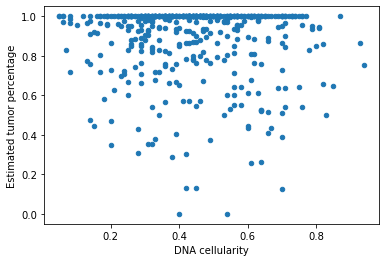

In [64]:
df_evaluation_real = pd.DataFrame.from_dict(dict_res_real)
df_evaluation_real_corr = df_evaluation_real.copy()
df_evaluation_real_rmse = df_evaluation_real.copy()
for method in dict_res_real.keys():
    for FSsetup in list_FSsetup_real:
        df_evaluation_real_corr.loc[FSsetup,method] = plot_estimates_cellularity(dict_res_real[method][FSsetup],cellularity_Kari)[1]
        df_evaluation_real_rmse.loc[FSsetup,method] = plot_estimates_cellularity(dict_res_real[method][FSsetup],cellularity_Kari)[2]


In [65]:
df_evaluation_real_corr.loc[list_FSsetup_real,]

BLADE     MuSiC BayesPrism CIBERSORTx      NNLS
top100markers  0.018116  0.233713   0.348153  -0.162834 -0.043141
top50markers   0.012939 -0.036265   0.338333   -0.12705 -0.036265
top20markers   0.066864  0.025015   0.272125  -0.142932  0.025015
top100DEGs    -0.044141  0.236092   0.336259  -0.140091 -0.074046
top50DEGs     -0.111418 -0.071575   0.339593  -0.119793 -0.071575

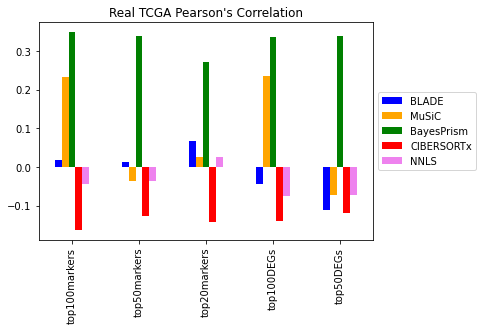

In [66]:
df_evaluation_real_corr.loc[list_FSsetup_real,].plot(kind='bar',title='Real TCGA Pearson\'s Correlation',color=['blue','orange','green','red','violet'])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [67]:
df_evaluation_real_rmse.loc[list_FSsetup_real,]

BLADE     MuSiC BayesPrism CIBERSORTx      NNLS
top100markers  0.285604  0.443443   0.373924   0.414458  0.535706
top50markers   0.246427  0.535914   0.355452   0.427219  0.535914
top20markers   0.219578  0.534506    0.42441   0.417016  0.534506
top100DEGs     0.202977  0.431035   0.348163   0.413827  0.525642
top50DEGs      0.226542  0.520958    0.35874   0.436888  0.520958

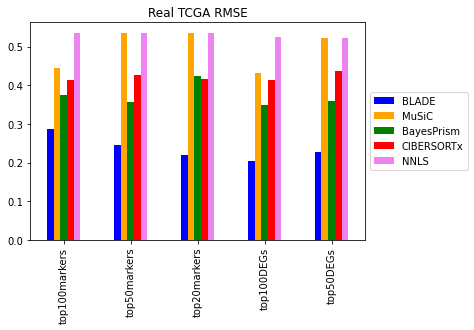

In [68]:
df_evaluation_real_rmse.loc[list_FSsetup_real,].plot(kind='bar',title='Real TCGA RMSE',color=['blue','orange','green','red','violet'])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

Pearson's correlation:  0.3481530473146458 rmse:  0.3739237918805647 r2 score:  -3.836534930435329
top100markers
Pearson's correlation:  0.3383329266885791 rmse:  0.35545167385274395 r2 score:  -3.3704812135532993
top50markers
Pearson's correlation:  0.272125101561991 rmse:  0.42440957842695765 r2 score:  -5.230723572179645
top20markers
Pearson's correlation:  0.3362585928131938 rmse:  0.3481630488111595 r2 score:  -3.1930832388240473
top100DEGs
Pearson's correlation:  0.33959275587327836 rmse:  0.35874009876813073 r2 score:  -3.4517213984789006
top50DEGs


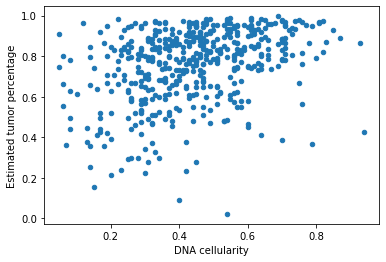

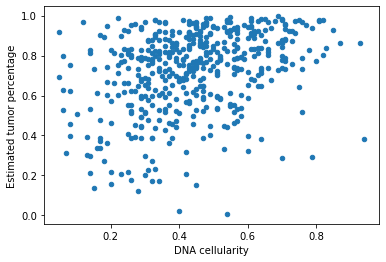

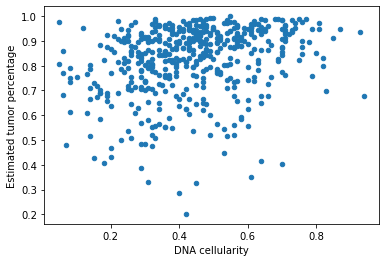

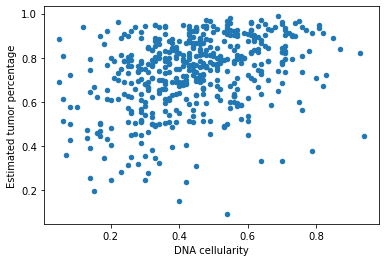

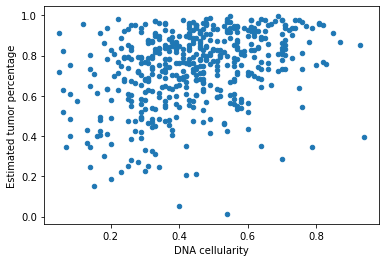

In [262]:
list_BP_pearson = []
list_BP_rmse = []
for FSsetup in list_FSsetup_real:
    BP_celltype_cellularity,BP_pearsoncorr,BP_rmse = plot_estimates_cellularity(dict_res_real['BayesPrism'][FSsetup],cellularity_Kari)
    list_BP_pearson.append(BP_pearsoncorr)
    list_BP_rmse.append(BP_rmse)
    print(FSsetup)

Pearson's correlation:  0.23371323394965712 rmse:  0.44344295564522573 r2 score:  -5.802110001068909
Pearson's correlation:  -0.036264985015604136 rmse:  0.5359144992178037 r2 score:  -8.934800363512439
Pearson's correlation:  0.025015063784447913 rmse:  0.5345063573395189 r2 score:  -8.882660593939994
Pearson's correlation:  0.23609160385266084 rmse:  0.43103464726355 r2 score:  -5.426766068770177
Pearson's correlation:  -0.07157483989059923 rmse:  0.5209576514431009 r2 score:  -8.387997653843382


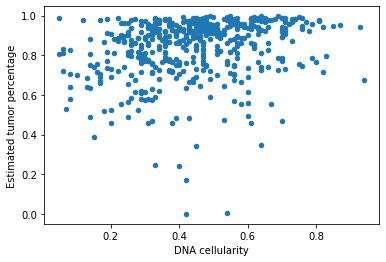

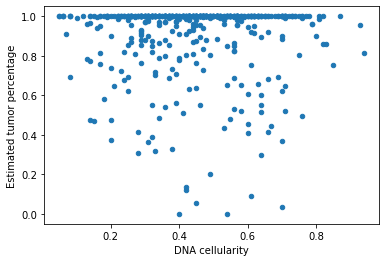

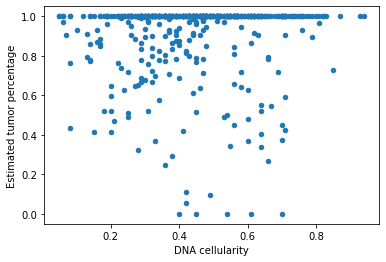

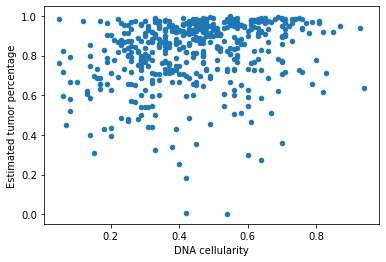

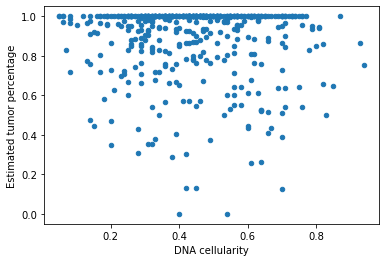

In [263]:
list_MuSiC_pearson = []
list_MuSiC_rmse = []
for FSsetup in list_FSsetup_real:
    celltype_cellularity,pearsoncorr,rmse = plot_estimates_cellularity(dict_res_real['MuSiC'][FSsetup],cellularity_Kari)
    list_MuSiC_pearson.append(pearsoncorr)
    list_MuSiC_rmse.append(rmse)

Pearson's correlation:  -0.043140535577506016 rmse:  0.5357061447766857 r2 score:  -8.927076902408832
Pearson's correlation:  -0.036264985015604136 rmse:  0.5359144992178037 r2 score:  -8.934800363512439
Pearson's correlation:  0.025015063784447913 rmse:  0.5345063573395189 r2 score:  -8.882660593939994
Pearson's correlation:  -0.07404557316346687 rmse:  0.5256415558173876 r2 score:  -8.557570594603721
Pearson's correlation:  -0.07157483989059923 rmse:  0.5209576514431009 r2 score:  -8.387997653843382


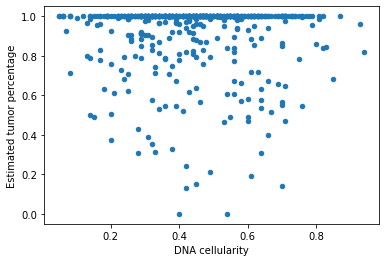

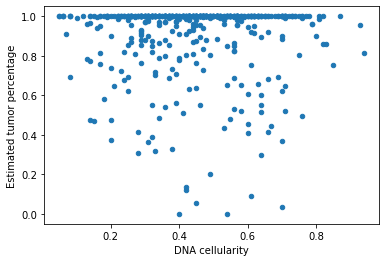

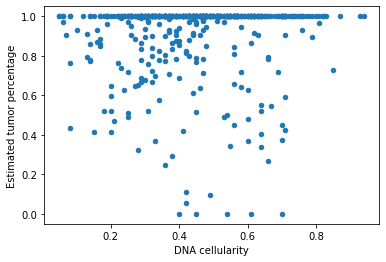

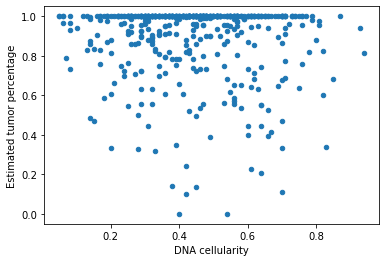

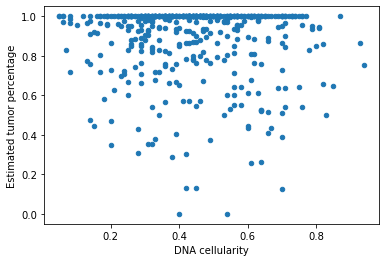

In [264]:
list_NNLS_pearson = []
list_NNLS_rmse = []
for FSsetup in list_FSsetup_real:
    celltype_cellularity,pearsoncorr,rmse = plot_estimates_cellularity(dict_res_real['NNLS'][FSsetup],cellularity_Kari)
    list_NNLS_pearson.append(pearsoncorr)
    list_NNLS_rmse.append(rmse)

Pearson's correlation:  0.018115528693327467 rmse:  0.28560440769020534 r2 score:  -1.8216162088611751
Pearson's correlation:  0.012939009360250737 rmse:  0.24642749011959536 r2 score:  -1.1006148814802028
Pearson's correlation:  0.0668643766131652 rmse:  0.21957795634896388 r2 score:  -0.6678062914375531
Pearson's correlation:  -0.044140870905106704 rmse:  0.2029765073992219 r2 score:  -0.42514705959449217
Pearson's correlation:  -0.11141784169590316 rmse:  0.2265422986275734 r2 score:  -0.7752794912783179


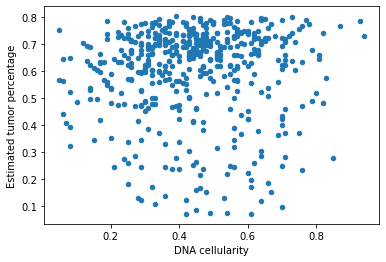

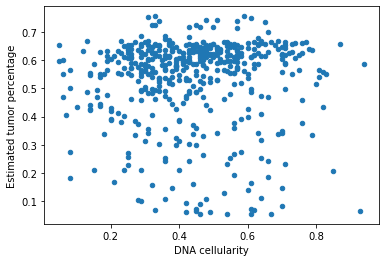

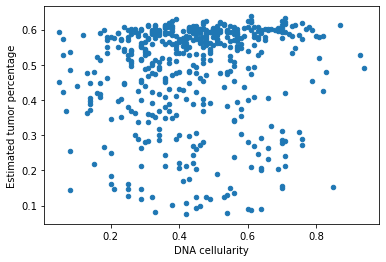

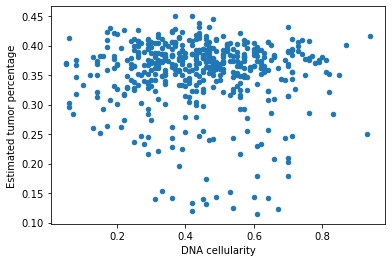

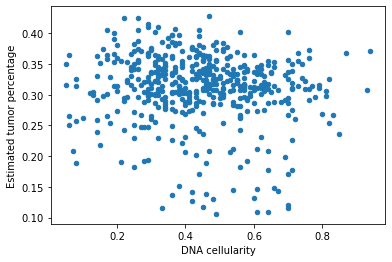

In [265]:
list_BLADE_pearson = []
list_BLADE_rmse = []
for FSsetup in list_FSsetup_real:
    celltype_cellularity,pearsoncorr,rmse = plot_estimates_cellularity(dict_res_real['BLADE'][FSsetup],cellularity_Kari)
    list_BLADE_pearson.append(pearsoncorr)
    list_BLADE_rmse.append(rmse)

Pearson's correlation:  -0.1628339094725728 rmse:  0.4144578719300101 r2 score:  -4.941948944458334
Pearson's correlation:  -0.1270499002162896 rmse:  0.42721897404991344 r2 score:  -5.313485623298276
Pearson's correlation:  -0.14293220406636348 rmse:  0.4170163530068367 r2 score:  -5.015535611096538
Pearson's correlation:  -0.14009085098862292 rmse:  0.41382686976137595 r2 score:  -4.92386976801596
Pearson's correlation:  -0.11979302221591324 rmse:  0.4368880818911269 r2 score:  -5.602501756216412


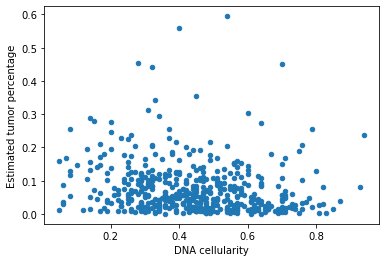

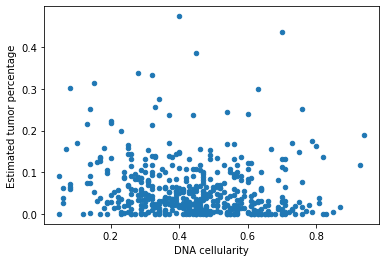

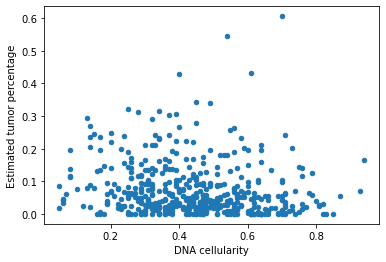

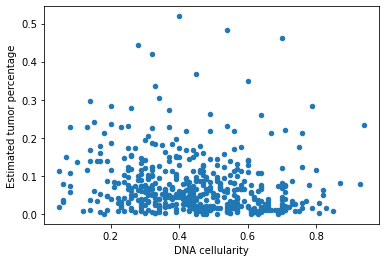

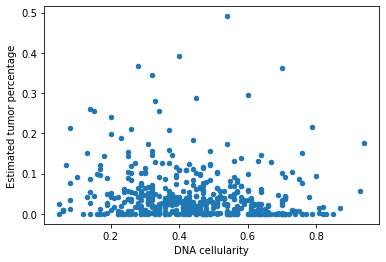

In [266]:
list_CIBERSORTx_pearson = []
list_CIBERSORTx_rmse = []
for FSsetup in list_FSsetup_real:
    celltype_cellularity,pearsoncorr,rmse = plot_estimates_cellularity(dict_res_real['CIBERSORTx'][FSsetup],cellularity_Kari)
    list_CIBERSORTx_pearson.append(pearsoncorr)
    list_CIBERSORTx_rmse.append(rmse)